<a href="https://colab.research.google.com/github/AlekseyCP/S1-Modelo_Predictivo/blob/main/S1_Modelo_Predictivo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE
import seaborn as sns
#Primera version
from sklearn.preprocessing import LabelEncoder


In [3]:
# Cargar dataset
from google.colab import files
import pandas as pd

uploaded = files.upload()
df = pd.read_excel("Dataset_Modelo_Predictivo.xlsx", sheet_name="Dataset")
df_area = df.copy()
#Primera versión que probamos
df_FirstVersion=pd.read_excel("Dataset_Modelo_Predictivo.xlsx", sheet_name="Dataset_Primera_Version")

# De manera provisional eliminamos las filas donde el curso de Física esté vacío
df = df[df['Fisica'].notna()]
df_FirstVersion=df_FirstVersion[df_FirstVersion['Fisica'].notna()]

# Mostrar vista general
print("Dimensiones del dataset:", df.shape)
df.head()

Saving Dataset_Modelo_Predictivo.xlsx to Dataset_Modelo_Predictivo.xlsx
Dimensiones del dataset: (193, 23)


,Grado,Sección,N° Orden,Algebra,Geometria,Aritmetica,RM,Matematica,CT,Fisica,...,P2,P3,P4,P5,P6,P7,P8,P9,P10,TieneAmbosPadres
0,1ero,A,1,B,B,B,B,B,A,A,...,Estudios de posgrado,Estudios de posgrado,Si,Si,Entre 1 y 2 horas,Dos comidas al día,"Si, tengo internet estable todo el tiempo",Trabajo ocasionalmente (fines de semana o vaca...,No tengo responsabilidades domésticas signific...,1
1,1ero,A,2,A,A,A,AD,AD,A,A,...,Estudios de posgrado,Superior Universitario,No,Si,Menos de 1 hora,Tres comidas al día,"Si, tengo internet estable todo el tiempo",No trabajo,Ayudo en casa pero no interfiere con mis estudios,1
2,1ero,A,3,A,A,A,A,A,AD,A,...,Superior Universitario,Superior técnico,Si,Si,Entre 1 y 2 horas,Tres comidas al día,"Si, tengo internet estable todo el tiempo",No trabajo,No tengo responsabilidades domésticas signific...,1
3,1ero,A,4,A,A,A,A,A,AD,A,...,Estudios de posgrado,Estudios de posgrado,Si,No,Entre 1 y 2 horas,Tres comidas al día,"Si, pero a veces se corta o es lento",No trabajo,Tengo bastantes responsabilidades que a veces ...,1
4,1ero,A,5,A,A,A,A,A,AD,A,...,Superior técnico,Superior técnico,No,Si,Más de 3 horas,Dos comidas al día,"Si, pero a veces se corta o es lento",No trabajo,Tengo bastantes responsabilidades que a veces ...,1


In [4]:
#Información de la primera versión del dataset
print(df_FirstVersion.info())

<class 'pandas.core.frame.DataFrame'>
Index: 193 entries, 0 to 217
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Grado           193 non-null    object
 1   Sección         193 non-null    object
 2   N° Orden        193 non-null    int64 
 3   Algebra         193 non-null    object
 4   Geometria       193 non-null    object
 5   Aritmetica      193 non-null    object
 6   RM              193 non-null    object
 7   Matematica      193 non-null    object
 8   CT              193 non-null    object
 9   Fisica          193 non-null    object
 10  Biologia        193 non-null    object
 11  Quimica         193 non-null    object
 12  P1              193 non-null    object
 13  P2              188 non-null    object
 14  P3              192 non-null    object
 15  P4              193 non-null    object
 16  P5              193 non-null    object
 17  P6              193 non-null    object
 18  P7             

In [5]:
#Información general del dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 193 entries, 0 to 217
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Grado             193 non-null    object
 1   Sección           193 non-null    object
 2   N° Orden          193 non-null    int64 
 3   Algebra           193 non-null    object
 4   Geometria         193 non-null    object
 5   Aritmetica        193 non-null    object
 6   RM                193 non-null    object
 7   Matematica        193 non-null    object
 8   CT                193 non-null    object
 9   Fisica            193 non-null    object
 10  Biologia          193 non-null    object
 11  Quimica           193 non-null    object
 12  P1                193 non-null    object
 13  P2                188 non-null    object
 14  P3                192 non-null    object
 15  P4                193 non-null    object
 16  P5                193 non-null    object
 17  P6                193

# PRIMERA VERSIÓN

In [29]:
def preparar_dataset(df):
    # Convertimos las notas a valores numéricos
    nota_map = {'AD': 4, 'A': 3, 'B': 2, 'C': 1}
    df = df.replace(nota_map)

    # Identificamos columnas categóricas (excluyendo ciertas columnas)
    cols_excluir = ['Grado', 'Sección', 'N° Orden']
    categorical_cols = [c for c in df.select_dtypes(include=['object']).columns if c not in cols_excluir]

    # Rellenamos valores nulos con 'Desconocido'
    df[categorical_cols] = df[categorical_cols].fillna("Desconocido")

    # Aplicamos One-Hot Encoding
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    # Mostramos información
    print("Dimensiones originales:", df.shape)
    print("Dimensiones después del One-Hot Encoding:", df_encoded.shape)
    print(df_encoded.info())

    return df_encoded


In [7]:
df_encoded3 = preparar_dataset(df_FirstVersion)

Dimensiones originales: (193, 24)
Dimensiones después del One-Hot Encoding: (193, 42)
<class 'pandas.core.frame.DataFrame'>
Index: 193 entries, 0 to 217
Data columns (total 42 columns):
 #   Column                                                                              Non-Null Count  Dtype 
---  ------                                                                              --------------  ----- 
 0   Grado                                                                               193 non-null    object
 1   Sección                                                                             193 non-null    int64 
 2   N° Orden                                                                            193 non-null    int64 
 3   Algebra                                                                             193 non-null    int64 
 4   Geometria                                                                           193 non-null    int64 
 5   Aritmetica               

/tmp/ipython-input-669173333.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(nota_map)


In [8]:
# Lo estamos separando por grupo de cursos de matematica y ct
target_ct = ['Fisica','Biologia','Quimica']
target_mate = ['Algebra','Geometria','Aritmetica','RM']

# Excluir columnas que no se usarán como features
exclude_cols = target_ct + target_mate + ['Matemática','CT','Grado', 'Sección', 'NúmeroOrden']
feature_cols2 = [c for c in df_encoded3.columns if c not in exclude_cols]

print("Total de columnas usadas como features:", len(feature_cols2))

Total de columnas usadas como features: 32


In [39]:
def entrenar_modelos(df, feature_cols, target_cols):
    resultados = []

    for target in target_cols:
        X = df[feature_cols]
        y = df[target]

        # Dividimos los datos
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )

        # Entrenar modelo
        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)

        # Predicciones
        y_pred = model.predict(X_test)

        # MATRIZ DE CONFUSIÓN
        cm = confusion_matrix(y_test, y_pred, labels=sorted(y.unique()))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y.unique()))

        # Mostrar gráfica
        plt.figure(figsize=(5,4))
        disp.plot(cmap='Blues', colorbar=False)
        plt.title(f"Matriz de Confusión - {target}")
        plt.show()

        # === MÉTRICAS ===
        resultados.append({
            'Curso': target,
            'Accuracy': round(accuracy_score(y_test, y_pred), 3),
            'Precision': round(precision_score(y_test, y_pred, average='macro', zero_division=0), 3),
            'F1-Score': round(f1_score(y_test, y_pred, average='macro', zero_division=0), 3)
        })

    # Devolver resultados en DataFrame
    return pd.DataFrame(resultados)

Modelos de los cursos de CT


<Figure size 500x400 with 0 Axes>

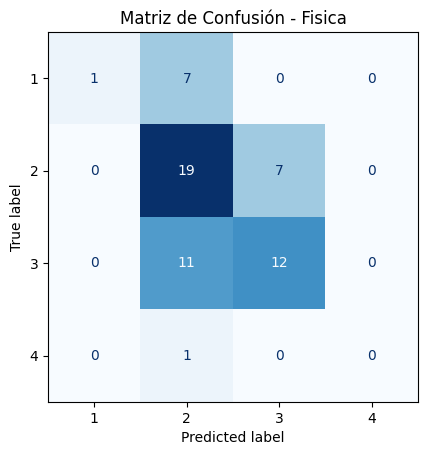

<Figure size 500x400 with 0 Axes>

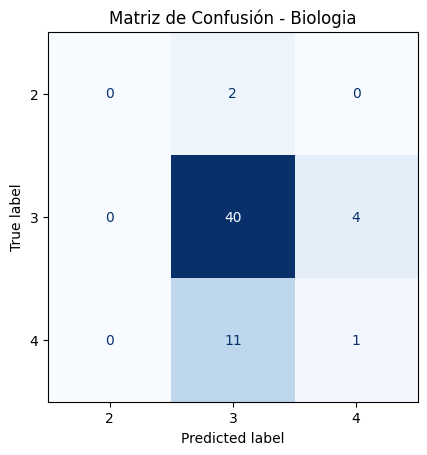

<Figure size 500x400 with 0 Axes>

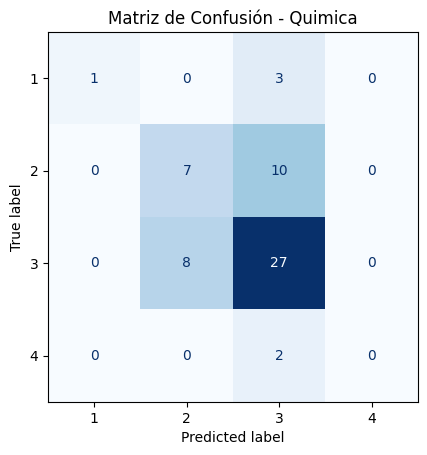

,Curso,Accuracy,Precision,F1-Score
0,Fisica,0.552,0.533,0.347
1,Biologia,0.707,0.318,0.314
2,Quimica,0.603,0.527,0.385



Modelos de los cursos de Mate


<Figure size 500x400 with 0 Axes>

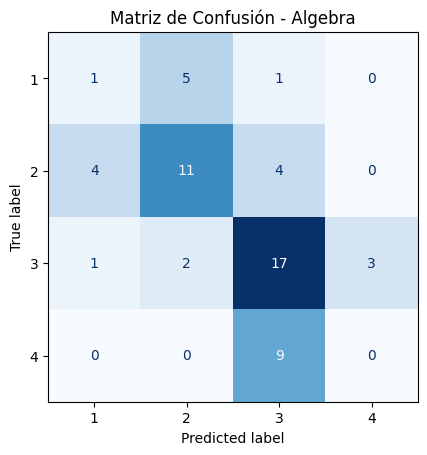

<Figure size 500x400 with 0 Axes>

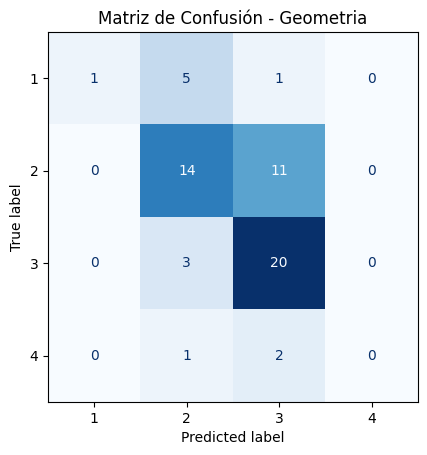

<Figure size 500x400 with 0 Axes>

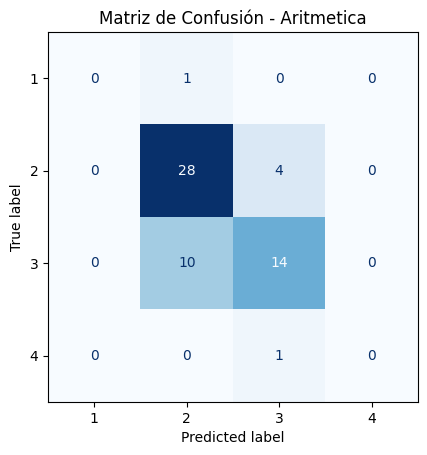

<Figure size 500x400 with 0 Axes>

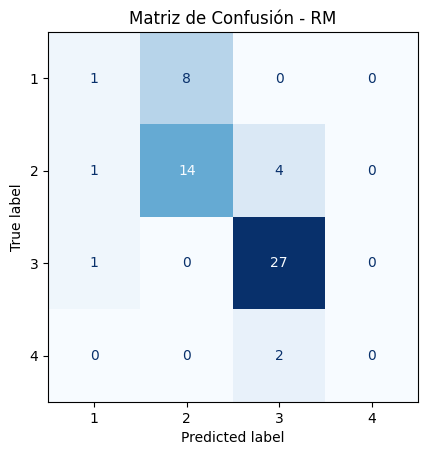

,Curso,Accuracy,Precision,F1-Score
0,Algebra,0.500,0.332,0.345
1,Geometria,0.603,0.549,0.384
2,Aritmetica,0.724,0.364,0.360
3,RM,0.724,0.447,0.434


In [10]:
print("Modelos de los cursos de CT")
resultados_ct = entrenar_modelos(df_encoded3, feature_cols2, target_ct)
display(resultados_ct)

print("\nModelos de los cursos de Mate")
resultados_mate = entrenar_modelos(df_encoded3, feature_cols2, target_mate)
display(resultados_mate)

In [40]:
#Probemos ahora con aprobado y desaprobado
def convertir_a_cumplimiento(df_encoded):
    df_encoded1=df_encoded.copy()
    # Mapeamos las notas numéricas a texto
    nota_map1 = {4: 'Cumplio', 3: 'Cumplio', 2: 'No cumplio', 1: 'No cumplio'}
    df_encoded1.replace(nota_map1, inplace=True)

    # Mostramos información básica
    print("Dimensiones después de la conversión:", df_encoded1.shape)
    display(df_encoded1.head())

    return df_encoded1


In [41]:
def convertir_a_numerico(df):
    nota_map2 = {'Cumplio': 1, 'No cumplio': 0}
    df.replace(nota_map2, inplace=True)
    print("Dimensiones después de la conversión:", df.shape)
    display(df.head())
    return df


In [42]:
df_encoded4=convertir_a_cumplimiento(df_encoded3)
df_encoded4=convertir_a_numerico(df_encoded4)

Dimensiones después de la conversión: (193, 42)


,Grado,Sección,N° Orden,Algebra,Geometria,Aritmetica,RM,Matematica,CT,Fisica,...,P7_Tres comidas al día,P7_Una comida al día,"P8_Si, tengo internet estable todo el tiempo",P8_Solo a veces (internet limitado),P9_Trabajo algunas horas entre semana,P9_Trabajo ocasionalmente (fines de semana o vacaciones),P9_Trabajo todos los días después del colegio,P10_No tengo responsabilidades domésticas significativas,P10_Tengo bastantes responsabilidades que a veces interfieren,P10_Tengo muchas responsabilidades que frecuentemente interfieren con mis estudios
0,1ero,Cumplio,No cumplio,No cumplio,No cumplio,No cumplio,No cumplio,No cumplio,Cumplio,Cumplio,...,False,False,True,False,False,True,False,True,False,False
1,1ero,Cumplio,No cumplio,Cumplio,Cumplio,Cumplio,Cumplio,Cumplio,Cumplio,Cumplio,...,True,False,True,False,False,False,False,False,False,False
2,1ero,Cumplio,Cumplio,Cumplio,Cumplio,Cumplio,Cumplio,Cumplio,Cumplio,Cumplio,...,True,False,True,False,False,False,False,True,False,False
3,1ero,Cumplio,Cumplio,Cumplio,Cumplio,Cumplio,Cumplio,Cumplio,Cumplio,Cumplio,...,True,False,False,False,False,False,False,False,True,False
4,1ero,Cumplio,5,Cumplio,Cumplio,Cumplio,Cumplio,Cumplio,Cumplio,Cumplio,...,False,False,False,False,False,False,False,False,True,False


Dimensiones después de la conversión: (193, 42)


/tmp/ipython-input-3415750851.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(nota_map2, inplace=True)


,Grado,Sección,N° Orden,Algebra,Geometria,Aritmetica,RM,Matematica,CT,Fisica,...,P7_Tres comidas al día,P7_Una comida al día,"P8_Si, tengo internet estable todo el tiempo",P8_Solo a veces (internet limitado),P9_Trabajo algunas horas entre semana,P9_Trabajo ocasionalmente (fines de semana o vacaciones),P9_Trabajo todos los días después del colegio,P10_No tengo responsabilidades domésticas significativas,P10_Tengo bastantes responsabilidades que a veces interfieren,P10_Tengo muchas responsabilidades que frecuentemente interfieren con mis estudios
0,1ero,1,0,0,0,0,0,0,1,1,...,False,False,True,False,False,True,False,True,False,False
1,1ero,1,0,1,1,1,1,1,1,1,...,True,False,True,False,False,False,False,False,False,False
2,1ero,1,1,1,1,1,1,1,1,1,...,True,False,True,False,False,False,False,True,False,False
3,1ero,1,1,1,1,1,1,1,1,1,...,True,False,False,False,False,False,False,False,True,False
4,1ero,1,5,1,1,1,1,1,1,1,...,False,False,False,False,False,False,False,False,True,False


Modelos de los cursos de CT


<Figure size 500x400 with 0 Axes>

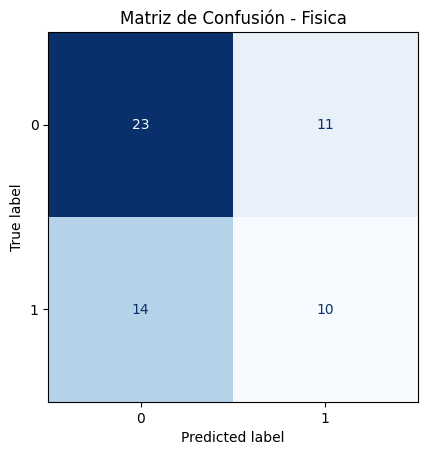

<Figure size 500x400 with 0 Axes>

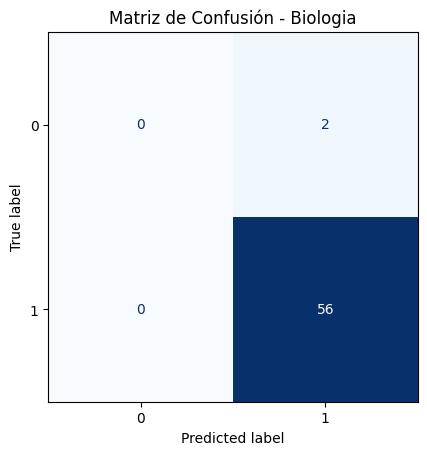

<Figure size 500x400 with 0 Axes>

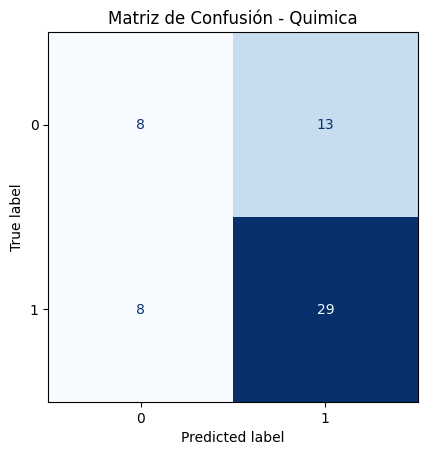

,Curso,Accuracy,Precision,F1-Score
0,Fisica,0.569,0.549,0.546
1,Biologia,0.966,0.483,0.491
2,Quimica,0.638,0.595,0.583



Modelos de los cursos de Mate


<Figure size 500x400 with 0 Axes>

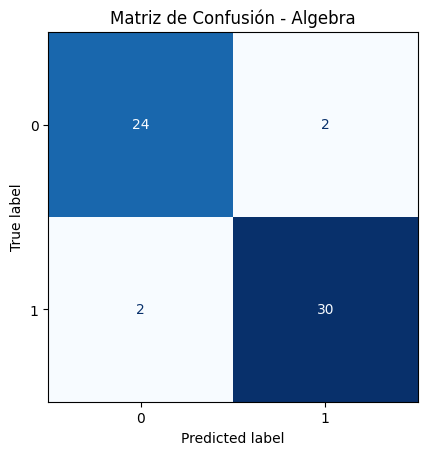

<Figure size 500x400 with 0 Axes>

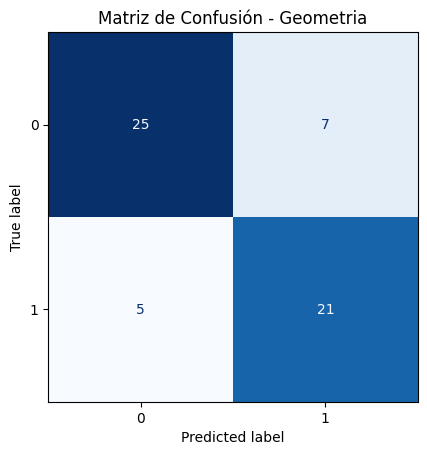

<Figure size 500x400 with 0 Axes>

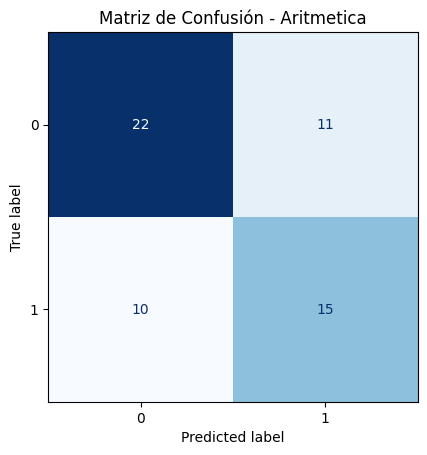

<Figure size 500x400 with 0 Axes>

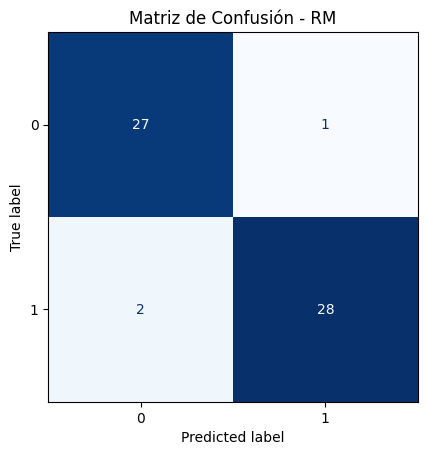

,Curso,Accuracy,Precision,F1-Score
0,Algebra,0.931,0.930,0.930
1,Geometria,0.793,0.792,0.792
2,Aritmetica,0.638,0.632,0.633
3,RM,0.948,0.948,0.948


In [43]:
#Probamos de nuevo el random forest
print("Modelos de los cursos de CT")
resultados_ct_random = entrenar_modelos(df_encoded4, feature_cols2, target_ct)
display(resultados_ct_random)

print("\nModelos de los cursos de Mate")
resultados_mate_random = entrenar_modelos(df_encoded4, feature_cols2, target_mate)
display(resultados_mate_random)

# SEGUNDA VERSIÓN

In [15]:
df_encoded=preparar_dataset(df)

Dimensiones originales: (193, 23)
Dimensiones después del One-Hot Encoding: (193, 41)
<class 'pandas.core.frame.DataFrame'>
Index: 193 entries, 0 to 217
Data columns (total 41 columns):
 #   Column                                                                              Non-Null Count  Dtype 
---  ------                                                                              --------------  ----- 
 0   Grado                                                                               193 non-null    object
 1   Sección                                                                             193 non-null    int64 
 2   N° Orden                                                                            193 non-null    int64 
 3   Algebra                                                                             193 non-null    int64 
 4   Geometria                                                                           193 non-null    int64 
 5   Aritmetica               

/tmp/ipython-input-669173333.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(nota_map)


In [16]:
# Excluir columnas que no se usarán como features
exclude_cols = target_ct + target_mate + ['Matemática','CT','Grado', 'Sección', 'NúmeroOrden']
feature_cols = [c for c in df_encoded.columns if c not in exclude_cols]

print("Total de columnas usadas como features:", len(feature_cols))

Total de columnas usadas como features: 31


Modelos de los cursos de CT


<Figure size 500x400 with 0 Axes>

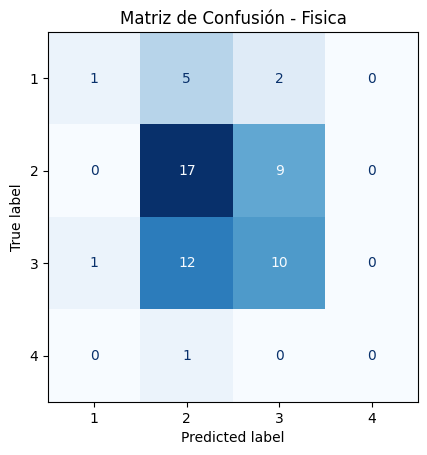

<Figure size 500x400 with 0 Axes>

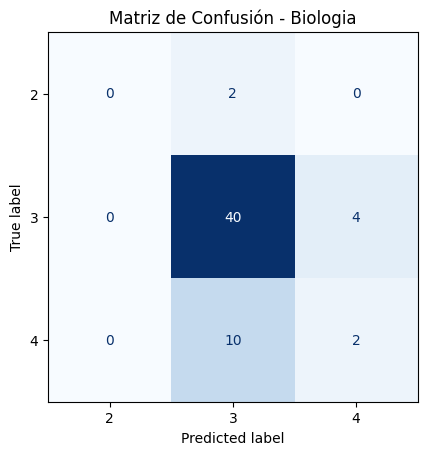

<Figure size 500x400 with 0 Axes>

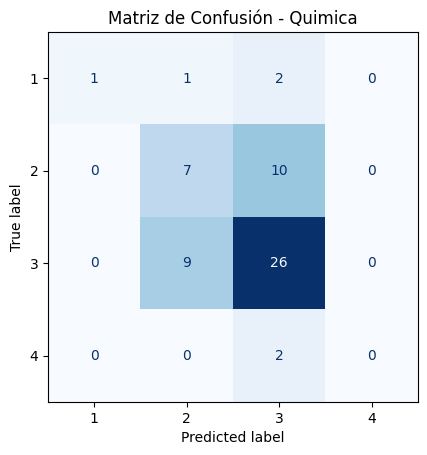

,Curso,Accuracy,Precision,F1-Score
0,Fisica,0.483,0.365,0.303
1,Biologia,0.724,0.368,0.352
2,Quimica,0.586,0.515,0.376



Modelos de los cursos de Mate


<Figure size 500x400 with 0 Axes>

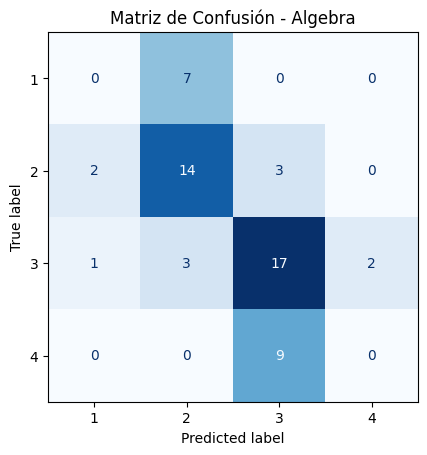

<Figure size 500x400 with 0 Axes>

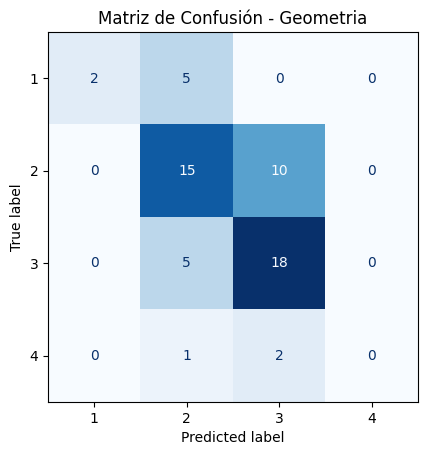

<Figure size 500x400 with 0 Axes>

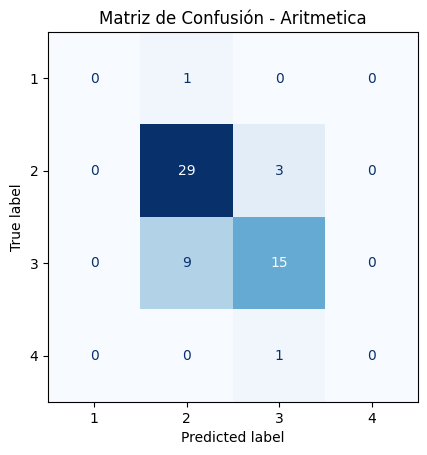

<Figure size 500x400 with 0 Axes>

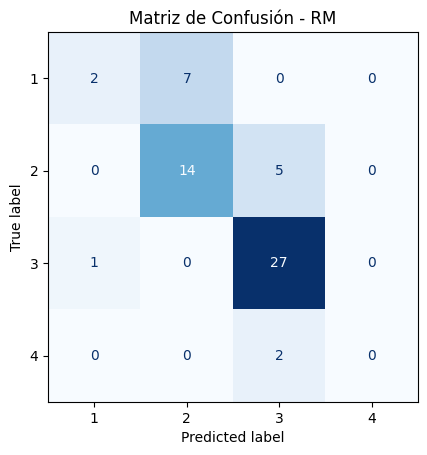

,Curso,Accuracy,Precision,F1-Score
0,Algebra,0.534,0.292,0.326
1,Geometria,0.603,0.544,0.428
2,Aritmetica,0.759,0.383,0.379
3,RM,0.741,0.532,0.476


In [17]:
print("Modelos de los cursos de CT")
resultados_ct = entrenar_modelos(df_encoded, feature_cols, target_ct)
display(resultados_ct)

print("\nModelos de los cursos de Mate")
resultados_mate = entrenar_modelos(df_encoded, feature_cols, target_mate)
display(resultados_mate)

In [18]:
df_encoded1=convertir_a_cumplimiento(df_encoded)
df_encoded1=convertir_a_numerico(df_encoded1)

Dimensiones después de la conversión: (193, 41)


,Grado,Sección,N° Orden,Algebra,Geometria,Aritmetica,RM,Matematica,CT,Fisica,...,P7_Tres comidas al día,P7_Una comida al día,"P8_Si, tengo internet estable todo el tiempo",P8_Solo a veces (internet limitado),P9_Trabajo algunas horas entre semana,P9_Trabajo ocasionalmente (fines de semana o vacaciones),P9_Trabajo todos los días después del colegio,P10_No tengo responsabilidades domésticas significativas,P10_Tengo bastantes responsabilidades que a veces interfieren,P10_Tengo muchas responsabilidades que frecuentemente interfieren con mis estudios
0,1ero,Cumplio,No cumplio,No cumplio,No cumplio,No cumplio,No cumplio,No cumplio,Cumplio,Cumplio,...,False,False,True,False,False,True,False,True,False,False
1,1ero,Cumplio,No cumplio,Cumplio,Cumplio,Cumplio,Cumplio,Cumplio,Cumplio,Cumplio,...,True,False,True,False,False,False,False,False,False,False
2,1ero,Cumplio,Cumplio,Cumplio,Cumplio,Cumplio,Cumplio,Cumplio,Cumplio,Cumplio,...,True,False,True,False,False,False,False,True,False,False
3,1ero,Cumplio,Cumplio,Cumplio,Cumplio,Cumplio,Cumplio,Cumplio,Cumplio,Cumplio,...,True,False,False,False,False,False,False,False,True,False
4,1ero,Cumplio,5,Cumplio,Cumplio,Cumplio,Cumplio,Cumplio,Cumplio,Cumplio,...,False,False,False,False,False,False,False,False,True,False


Dimensiones después de la conversión: (193, 41)


/tmp/ipython-input-3415750851.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(nota_map2, inplace=True)


,Grado,Sección,N° Orden,Algebra,Geometria,Aritmetica,RM,Matematica,CT,Fisica,...,P7_Tres comidas al día,P7_Una comida al día,"P8_Si, tengo internet estable todo el tiempo",P8_Solo a veces (internet limitado),P9_Trabajo algunas horas entre semana,P9_Trabajo ocasionalmente (fines de semana o vacaciones),P9_Trabajo todos los días después del colegio,P10_No tengo responsabilidades domésticas significativas,P10_Tengo bastantes responsabilidades que a veces interfieren,P10_Tengo muchas responsabilidades que frecuentemente interfieren con mis estudios
0,1ero,1,0,0,0,0,0,0,1,1,...,False,False,True,False,False,True,False,True,False,False
1,1ero,1,0,1,1,1,1,1,1,1,...,True,False,True,False,False,False,False,False,False,False
2,1ero,1,1,1,1,1,1,1,1,1,...,True,False,True,False,False,False,False,True,False,False
3,1ero,1,1,1,1,1,1,1,1,1,...,True,False,False,False,False,False,False,False,True,False
4,1ero,1,5,1,1,1,1,1,1,1,...,False,False,False,False,False,False,False,False,True,False


Modelos de los cursos de CT


<Figure size 500x400 with 0 Axes>

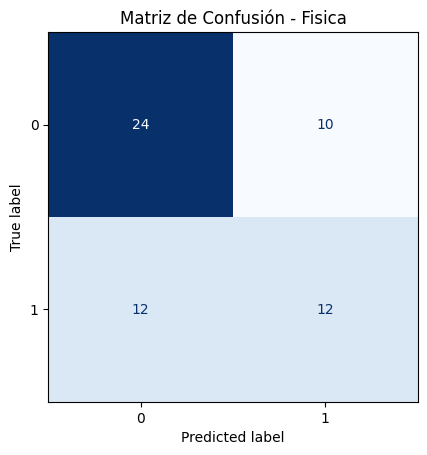

<Figure size 500x400 with 0 Axes>

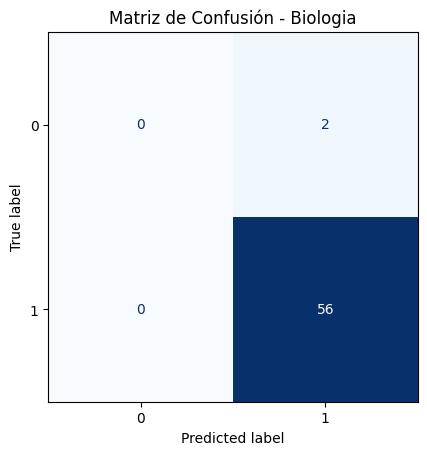

<Figure size 500x400 with 0 Axes>

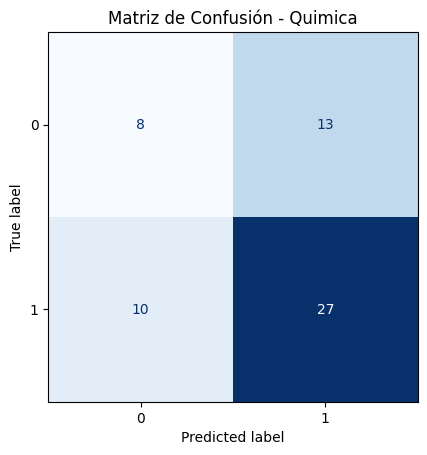

,Curso,Accuracy,Precision,F1-Score
0,Fisica,0.621,0.606,0.604
1,Biologia,0.966,0.483,0.491
2,Quimica,0.603,0.560,0.556



Modelos de los cursos de Mate


<Figure size 500x400 with 0 Axes>

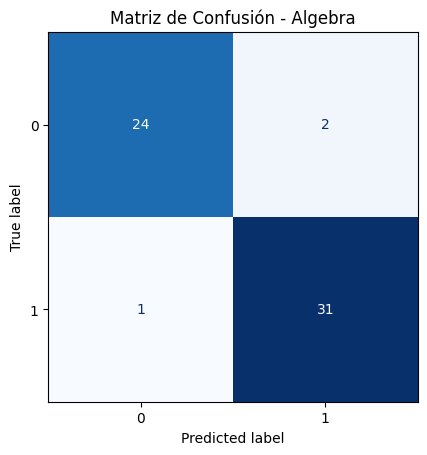

<Figure size 500x400 with 0 Axes>

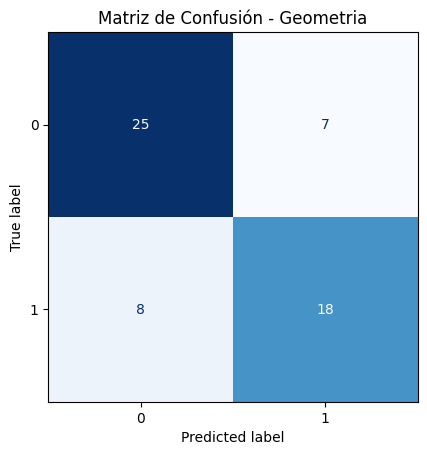

<Figure size 500x400 with 0 Axes>

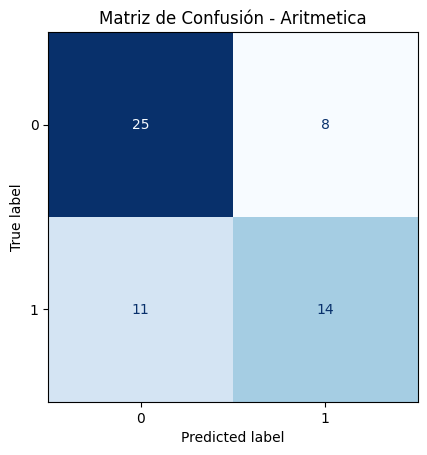

<Figure size 500x400 with 0 Axes>

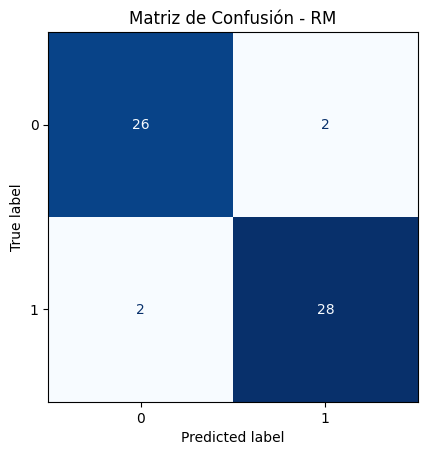

,Curso,Accuracy,Precision,F1-Score
0,Algebra,0.948,0.950,0.948
1,Geometria,0.741,0.739,0.738
2,Aritmetica,0.672,0.665,0.660
3,RM,0.931,0.931,0.931


In [19]:
#Probamos de nuevo el random forest
print("Modelos de los cursos de CT")
resultados_ct_random = entrenar_modelos(df_encoded1, feature_cols, target_ct)
display(resultados_ct_random)

print("\nModelos de los cursos de Mate")
resultados_mate_random = entrenar_modelos(df_encoded1, feature_cols, target_mate)
display(resultados_mate_random)

# PRUEBAS USAR DATA SINTETICA CON SMOTE

In [20]:
#Ahora probare usar SMOTE, que puede crear data sintetica de las clases minoritarias

def entrenar_modelos_SMOTE(df, feature_cols, target_cols):
    resultados = []

    for target in target_cols:
        X = df[feature_cols]
        y = df[target]

        # Dividir los datos
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )

        # 💡 Aplicar SMOTE solo al conjunto de entrenamiento
        smote = SMOTE(random_state=42, k_neighbors=1)
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

        # Entrenar modelo con los datos balanceados
        model = RandomForestClassifier(random_state=42)
        model.fit(X_train_res, y_train_res)

        # Predicciones
        y_pred = model.predict(X_test)

        # === MATRIZ DE CONFUSIÓN ===
        cm = confusion_matrix(y_test, y_pred, labels=sorted(y.unique()))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y.unique()))

        plt.figure(figsize=(5,4))
        disp.plot(cmap='Blues', colorbar=False)
        plt.title(f"Matriz de Confusión - {target}")
        plt.show()

        # === MÉTRICAS ===
        resultados.append({
            'Curso': target,
            'Accuracy': round(accuracy_score(y_test, y_pred), 3),
            'Precision': round(precision_score(y_test, y_pred, average='macro', zero_division=0), 3),
            'F1-Score': round(f1_score(y_test, y_pred, average='macro', zero_division=0), 3)
        })

    # Devolver resultados en DataFrame
    return pd.DataFrame(resultados)

In [21]:
def entrenar_modelos_SMOTE1(df, feature_cols, target_cols):
    resultados = []

    for target in target_cols:
        X = df[feature_cols]
        y = df[target]

        # Verificamos si hay más de una clase
        if len(y.unique()) <= 1:
            print(f"El target '{target}' tiene solo una clase, se omite.")
            continue

        # División del dataset
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )

        # Contamos cuántas muestras hay por clase
        conteo = Counter(y_train)
        min_samples = min(conteo.values())

        # Si una clase tiene solo 1 muestra, no se puede aplicar SMOTE
        if min_samples < 2:
            print(f"El target '{target}' tiene una clase con solo 1 muestra, no se aplica SMOTE.")
            X_res, y_res = X_train, y_train
        else:
            # Ajustamos k_neighbors según el mínimo de muestras
            k_value = max(1, min(5, min_samples - 1))
            smote = SMOTE(random_state=42, k_neighbors=k_value)
            X_res, y_res = smote.fit_resample(X_train, y_train)

        # Entrenamiento
        model = RandomForestClassifier(random_state=42)
        model.fit(X_res, y_res)

        # Predicción
        y_pred = model.predict(X_test)

        # Matriz de confusión
        cm = confusion_matrix(y_test, y_pred, labels=sorted(y.unique()))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y.unique()))
        plt.figure(figsize=(5, 4))
        disp.plot(cmap='Blues', colorbar=False)
        plt.title(f"Matriz de Confusión - {target}")
        plt.show()

        # Métricas
        resultados.append({
            'Curso': target,
            'Accuracy': round(accuracy_score(y_test, y_pred), 3),
            'Precision': round(precision_score(y_test, y_pred, average='macro', zero_division=0), 3),
            'F1-Score': round(f1_score(y_test, y_pred, average='macro', zero_division=0), 3)
        })

    return pd.DataFrame(resultados)

Modelos de los cursos de CT


<Figure size 500x400 with 0 Axes>

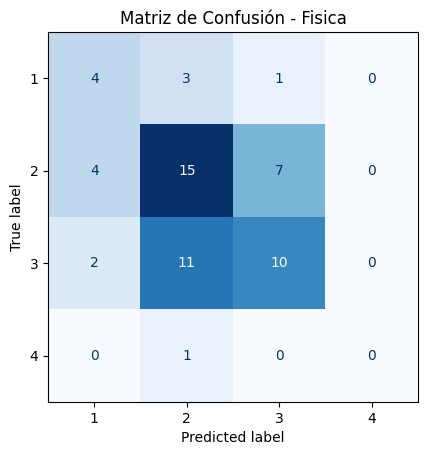

<Figure size 500x400 with 0 Axes>

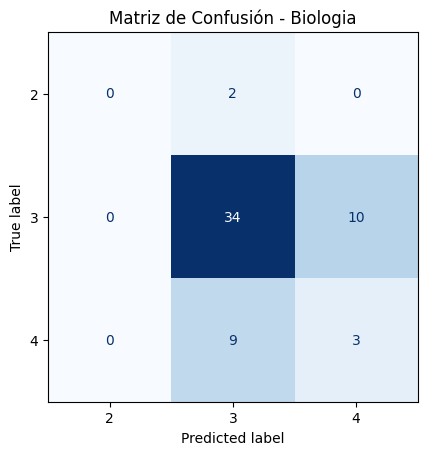

<Figure size 500x400 with 0 Axes>

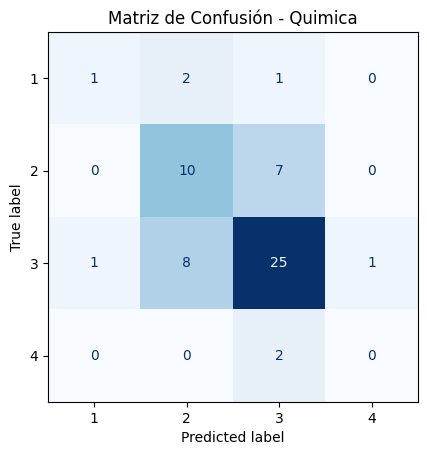

,Curso,Accuracy,Precision,F1-Score
0,Fisica,0.500,0.364,0.367
1,Biologia,0.638,0.329,0.335
2,Quimica,0.621,0.429,0.397



Modelos de los cursos de Mate


<Figure size 500x400 with 0 Axes>

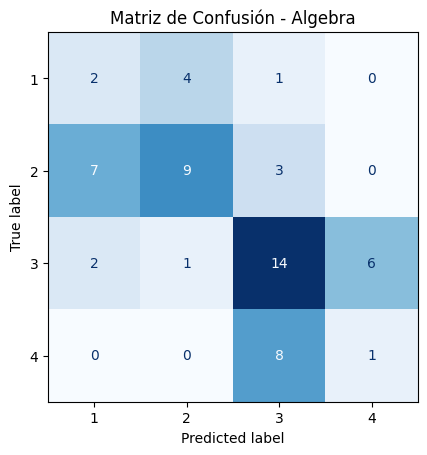

<Figure size 500x400 with 0 Axes>

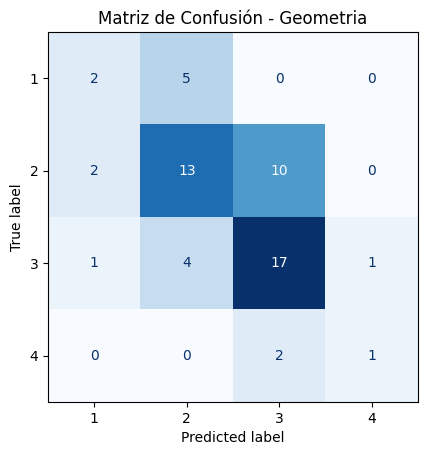

El target 'Aritmetica' tiene una clase con solo 1 muestra, no se aplica SMOTE.


<Figure size 500x400 with 0 Axes>

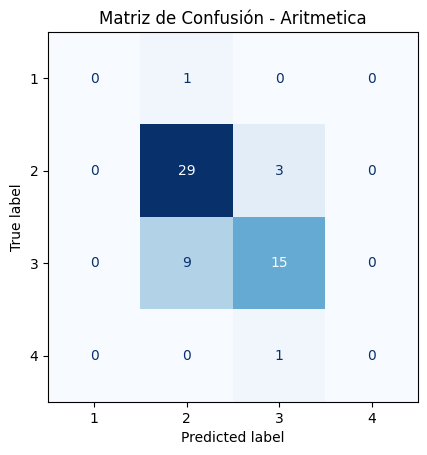

<Figure size 500x400 with 0 Axes>

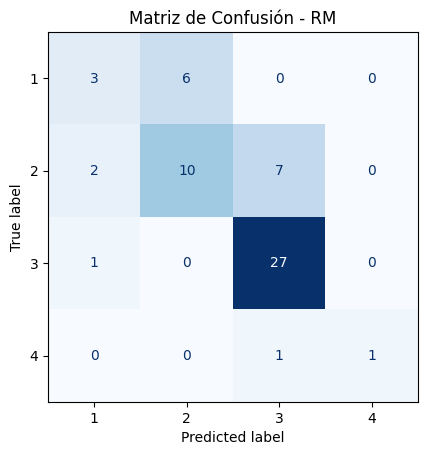

,Curso,Accuracy,Precision,F1-Score
0,Algebra,0.448,0.376,0.366
1,Geometria,0.569,0.519,0.485
2,Aritmetica,0.759,0.383,0.379
3,RM,0.707,0.724,0.624


In [22]:
#Probamos de nuevo el random forest
print("Modelos de los cursos de CT")
resultados_ct_smote_1 = entrenar_modelos_SMOTE1(df_encoded, feature_cols, target_ct)
display(resultados_ct_smote_1)

print("\nModelos de los cursos de Mate")
resultados_mate_smote_1 = entrenar_modelos_SMOTE1(df_encoded, feature_cols, target_mate)
display(resultados_mate_smote_1)



Modelos de los cursos de CT


<Figure size 500x400 with 0 Axes>

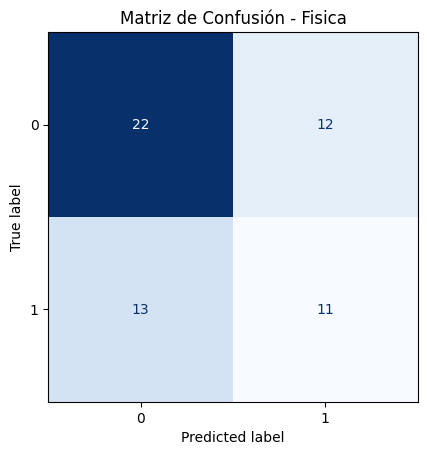

<Figure size 500x400 with 0 Axes>

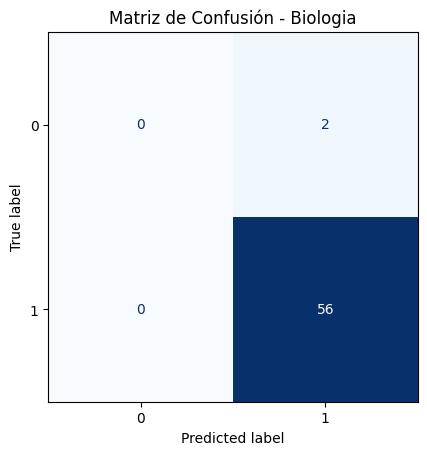

<Figure size 500x400 with 0 Axes>

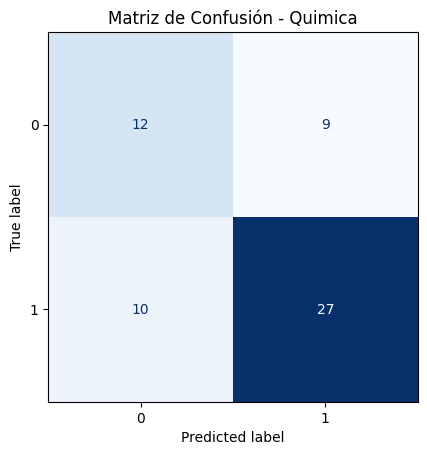

,Curso,Accuracy,Precision,F1-Score
0,Fisica,0.569,0.553,0.553
1,Biologia,0.966,0.483,0.491
2,Quimica,0.672,0.648,0.649



Modelos de los cursos de Mate


<Figure size 500x400 with 0 Axes>

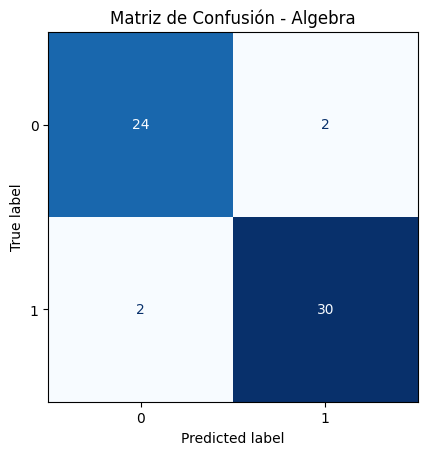

<Figure size 500x400 with 0 Axes>

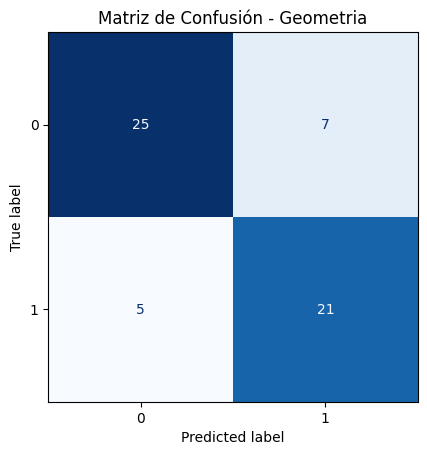

<Figure size 500x400 with 0 Axes>

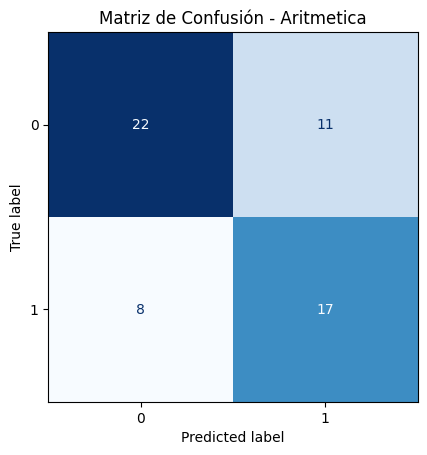

<Figure size 500x400 with 0 Axes>

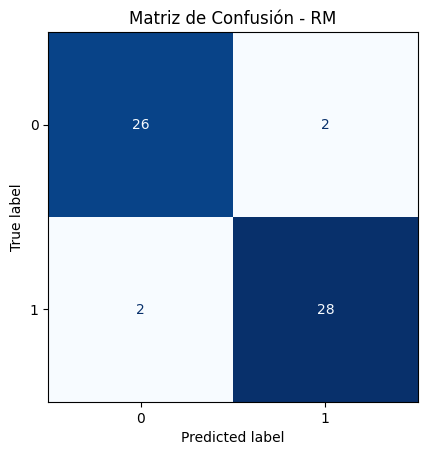

,Curso,Accuracy,Precision,F1-Score
0,Algebra,0.931,0.930,0.930
1,Geometria,0.793,0.792,0.792
2,Aritmetica,0.672,0.670,0.670
3,RM,0.931,0.931,0.931


In [ ]:
#Probamos de nuevo el random forest
print("Modelos de los cursos de CT")
resultados_ct_smote = entrenar_modelos_SMOTE(df_encoded1, feature_cols, target_ct)
display(resultados_ct_smote)

print("\nModelos de los cursos de Mate")
resultados_mate_smote = entrenar_modelos_SMOTE(df_encoded1, feature_cols, target_mate)
display(resultados_mate_smote)

#PRUEBAS POR AREAS

In [23]:
# Consideraremos por ahora los alumnos que tienen sus notas de las áreas completas
df_area = df_area[df_area[['CT', 'Matematica']].notna().all(axis=1)]

# Verificar resultado
df_area.info()

<class 'pandas.core.frame.DataFrame'>
Index: 214 entries, 0 to 217
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Grado             214 non-null    object
 1   Sección           214 non-null    object
 2   N° Orden          214 non-null    int64 
 3   Algebra           214 non-null    object
 4   Geometria         214 non-null    object
 5   Aritmetica        214 non-null    object
 6   RM                214 non-null    object
 7   Matematica        214 non-null    object
 8   CT                214 non-null    object
 9   Fisica            193 non-null    object
 10  Biologia          214 non-null    object
 11  Quimica           214 non-null    object
 12  P1                214 non-null    object
 13  P2                207 non-null    object
 14  P3                213 non-null    object
 15  P4                214 non-null    object
 16  P5                214 non-null    object
 17  P6                214

In [24]:
nota_map3 = {'AD':1 , 'A': 1, 'B':0, 'C':0}
df_area.replace(nota_map3, inplace=True)

cols_excluir = ['Grado', 'Sección', 'NúmeroOrden']
categorical_cols1 = [c for c in df_area.select_dtypes(include=['object']).columns if c not in cols_excluir]

# Aplicamos One-Hot Encoding correctamente
df_encoded2 = pd.get_dummies(df_area, columns=categorical_cols1, drop_first=True)

df_encoded2 = df_encoded2.drop(columns=['Grado', 'Sección', 'N° Orden','Algebra','Geometria','Aritmetica','RM', 'Fisica','Biologia','Quimica'], errors='ignore')

# Mostramos las primeras filas
df_encoded2.head()

/tmp/ipython-input-243425236.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_area.replace(nota_map3, inplace=True)


,Matematica,CT,TieneAmbosPadres,P1_Mujer,P2_Primaria,P2_Secundaria,P2_Superior Universitario,P2_Superior técnico,P3_Primaria,P3_Secundaria,...,P7_Tres comidas al día,P7_Una comida al día,"P8_Si, tengo internet estable todo el tiempo",P8_Solo a veces (internet limitado),P9_Trabajo algunas horas entre semana,P9_Trabajo ocasionalmente (fines de semana o vacaciones),P9_Trabajo todos los días después del colegio,P10_No tengo responsabilidades domésticas significativas,P10_Tengo bastantes responsabilidades que a veces interfieren,P10_Tengo muchas responsabilidades que frecuentemente interfieren con mis estudios
0,0,1,1,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,True,False,False
1,1,1,1,False,False,False,False,False,False,False,...,True,False,True,False,False,False,False,False,False,False
2,1,1,1,True,False,False,True,False,False,False,...,True,False,True,False,False,False,False,True,False,False
3,1,1,1,True,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False
4,1,1,1,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False


In [25]:
# Lo estamos separando por grupo de cursos de matematica y ct
target_areas = ['Matematica','CT']

# Excluir columnas que no se usarán como features
exclude_cols1 = target_areas
feature_cols1 = [c for c in df_encoded2.columns if c not in exclude_cols1]

print("Total de columnas usadas como features:", len(feature_cols1))

Total de columnas usadas como features: 26


Modelos de las areas


<Figure size 500x400 with 0 Axes>

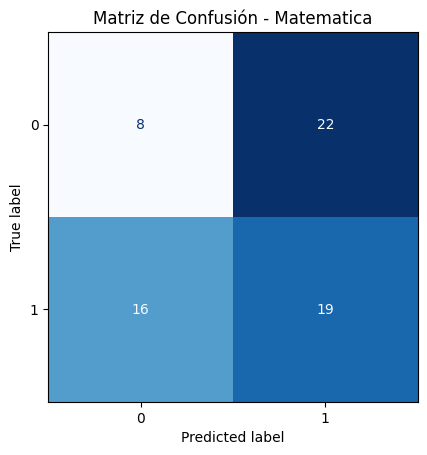

<Figure size 500x400 with 0 Axes>

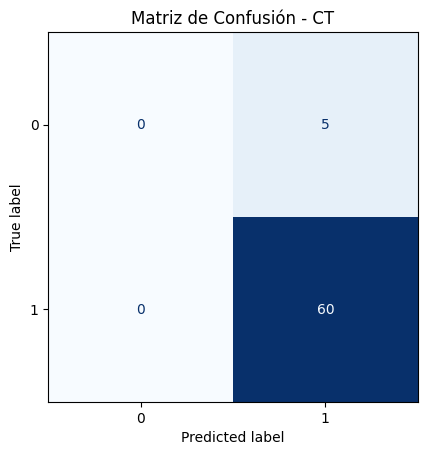

,Curso,Accuracy,Precision,F1-Score
0,Matematica,0.415,0.398,0.398
1,CT,0.923,0.462,0.480


In [26]:
print("Modelos de las areas")
resultados_areas = entrenar_modelos(df_encoded2, feature_cols1, target_areas)
display(resultados_areas)

# PRUEBAS CON ORIGINALES CON REGRESIÓN LOGISTICA

In [27]:
def entrenar_modelos_logistic(df, feature_cols, target_cols):
    resultados = []

    for target in target_cols:
        X = df[feature_cols]
        y = df[target]

        # División de los datos
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )

        # Modelo de Regresión Logística
        model = LogisticRegression(
            random_state=42,
            class_weight='balanced',
            max_iter=1000,        # asegura convergencia
            solver='lbfgs',       # compatible con multiclase
            multi_class='auto'    # detección automática
        )
        model.fit(X_train, y_train)

        # Predicciones
        y_pred = model.predict(X_test)

        # === MATRIZ DE CONFUSIÓN ===
        cm = confusion_matrix(y_test, y_pred, labels=sorted(y.unique()))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y.unique()))

        # Mostrar gráfica
        plt.figure(figsize=(5, 4))
        disp.plot(cmap='Blues', colorbar=False)
        plt.title(f"Matriz de Confusión - {target}")
        plt.show()

        # MÉTRICAS
        resultados.append({
            'Curso': target,
            'Accuracy': round(accuracy_score(y_test, y_pred), 3),
            'Precision': round(precision_score(y_test, y_pred, average='macro', zero_division=0), 3),
            'F1-Score': round(f1_score(y_test, y_pred, average='macro', zero_division=0), 3)
        })

    # Devolver resultados en DataFrame
    return pd.DataFrame(resultados)

Modelos de los cursos de CT


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


<Figure size 500x400 with 0 Axes>

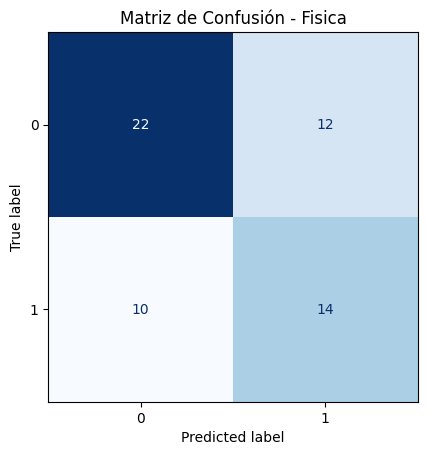

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


<Figure size 500x400 with 0 Axes>

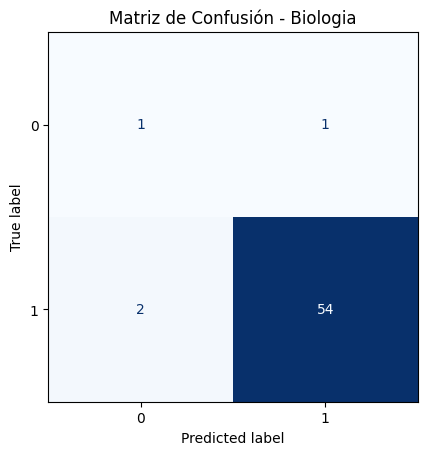

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


<Figure size 500x400 with 0 Axes>

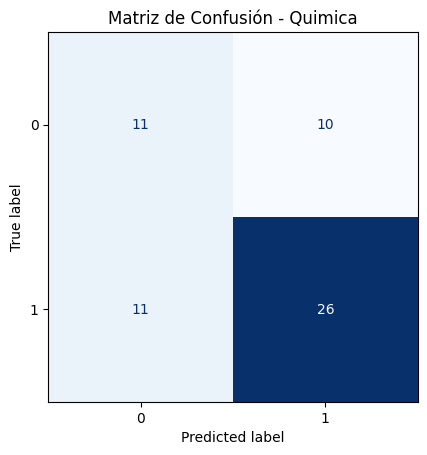

,Curso,Accuracy,Precision,F1-Score
0,Fisica,0.621,0.613,0.613
1,Biologia,0.948,0.658,0.686
2,Quimica,0.638,0.611,0.612



Modelos de los cursos de Mate


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


<Figure size 500x400 with 0 Axes>

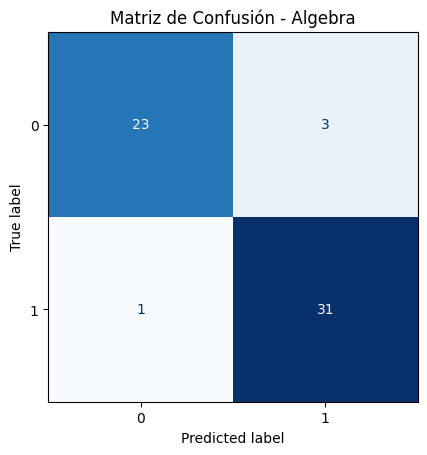

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


<Figure size 500x400 with 0 Axes>

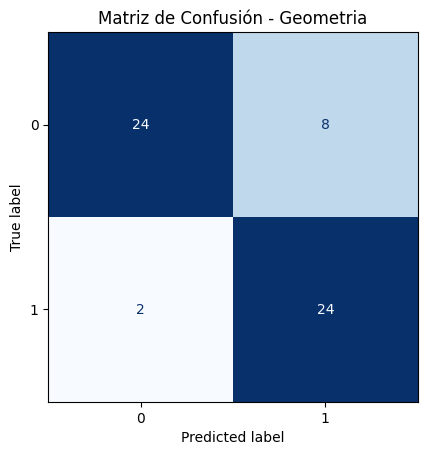

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


<Figure size 500x400 with 0 Axes>

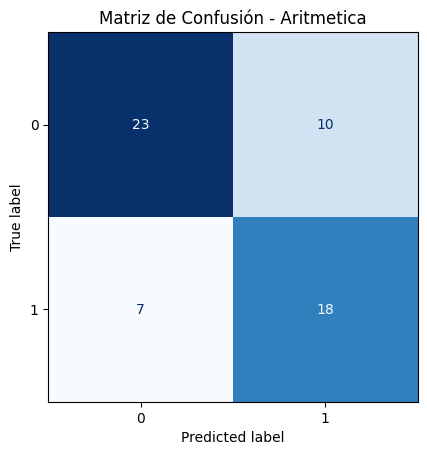

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


<Figure size 500x400 with 0 Axes>

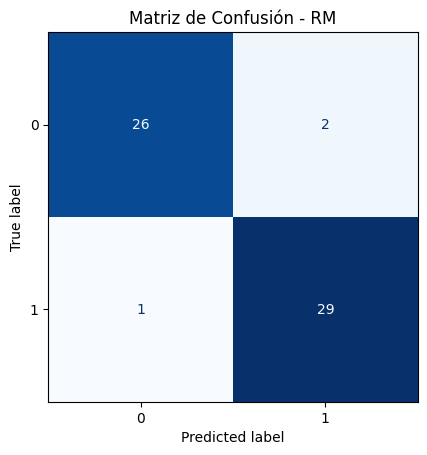

,Curso,Accuracy,Precision,F1-Score
0,Algebra,0.931,0.935,0.930
1,Geometria,0.828,0.837,0.828
2,Aritmetica,0.707,0.705,0.705
3,RM,0.948,0.949,0.948


In [28]:
#Probamos el modelo de regresión Logistica con los datos que obtuvimos mejores resultados
print("Modelos de los cursos de CT")
resultados_ct_logistica = entrenar_modelos_logistic(df_encoded1, feature_cols, target_ct)
display(resultados_ct_logistica)

print("\nModelos de los cursos de Mate")
resultados_mate_logistica = entrenar_modelos_logistic(df_encoded1, feature_cols, target_mate)
display(resultados_mate_logistica)

# COMPARACIÓN ENTRE RESULTADOS OBTENIDOS CON RANDOM FOREST Y R. LOGISTICA

In [ ]:
def comparar_metricas_modelos(resultados_modelo1, resultados_modelo2, nombre_modelo1="Modelo 1", nombre_modelo2="Modelo 2"):
    # Convertimos a DataFrames por seguridad
    df1 = pd.DataFrame(resultados_modelo1).copy()
    df2 = pd.DataFrame(resultados_modelo2).copy()

    # Agregamos nombres de modelo
    df1["Modelo"] = nombre_modelo1
    df2["Modelo"] = nombre_modelo2

    # Unimos ambos
    df_comparacion = pd.concat([df1, df2])

    # Identificamos las métricas
    metricas = [col for col in df_comparacion.columns if col not in ["Curso", "Modelo"]]

    # --- Graficamos cada métrica ---
    for metrica in metricas:
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(
            data=df_comparacion,
            x="Curso",
            y=metrica,
            hue="Modelo",
            palette="viridis",
            ci=None
        )

        # Etiquetas con valores (porcentajes)
        for p in ax.patches:
            valor = p.get_height()
            ax.text(
                p.get_x() + p.get_width() / 2.,
                valor + 0.01,
                f"{valor*100:.1f}%",  # Muestra porcentaje
                ha="center",
                va="bottom",
                fontsize=10,
                color="black"
            )

        plt.title(f"Comparación de {metrica} por curso")
        plt.ylabel("Valor (%)")
        plt.xlabel("Curso")
        plt.ylim(0, 1.1)
        plt.legend(title="Modelo")
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.show()

/tmp/ipython-input-2427006153.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


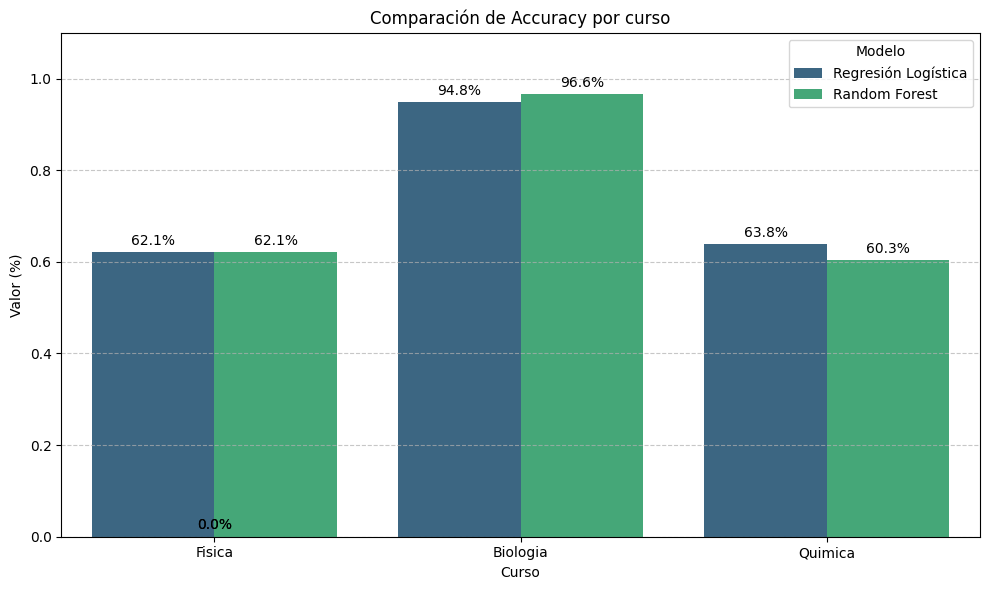

/tmp/ipython-input-2427006153.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


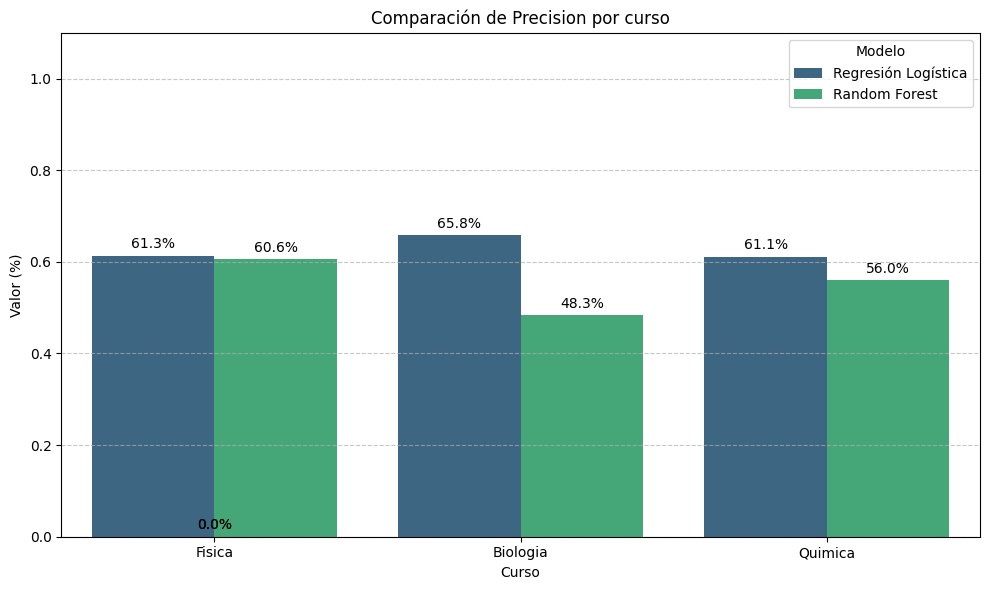

/tmp/ipython-input-2427006153.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


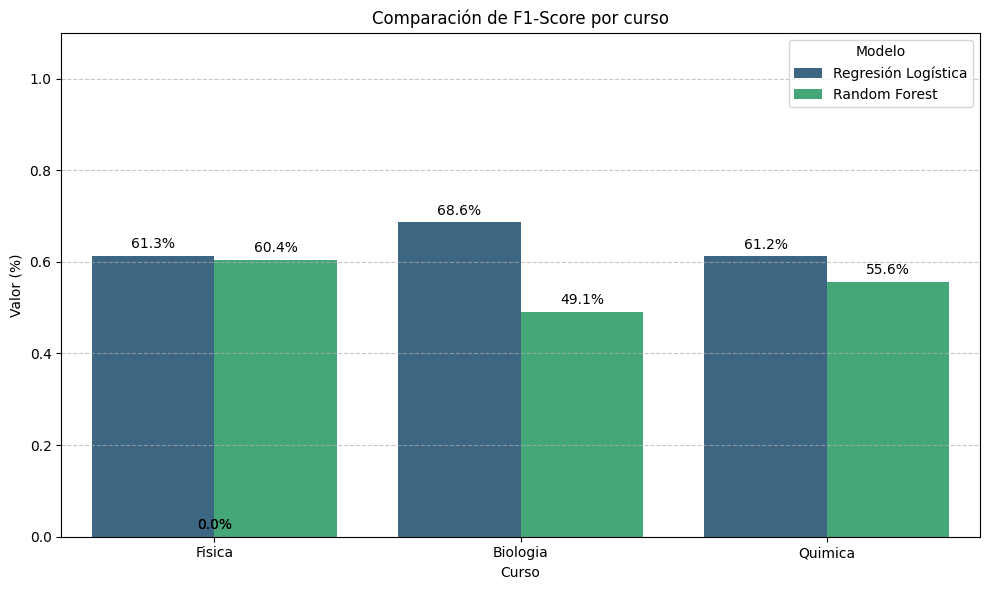

In [ ]:
comparar_metricas_modelos(
    resultados_ct_logistica,
    resultados_ct_random,
    nombre_modelo1="Regresión Logística",
    nombre_modelo2="Random Forest"
)

/tmp/ipython-input-2427006153.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


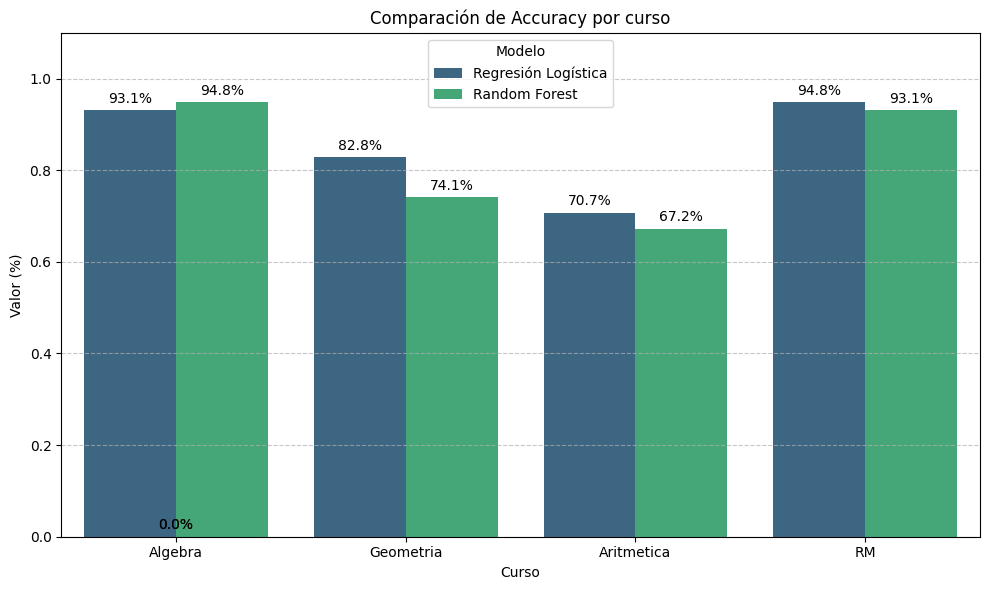

/tmp/ipython-input-2427006153.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


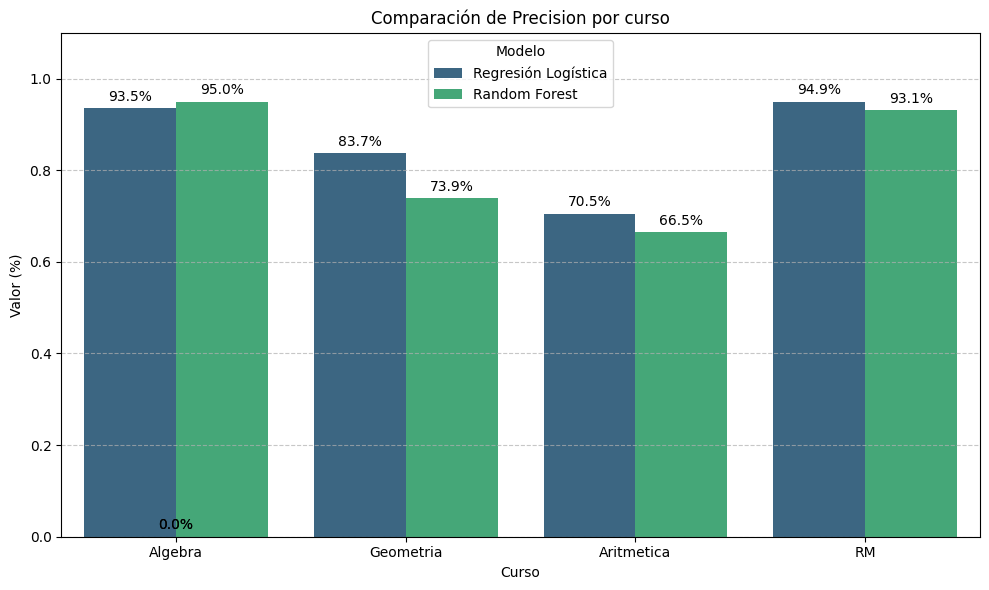

/tmp/ipython-input-2427006153.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


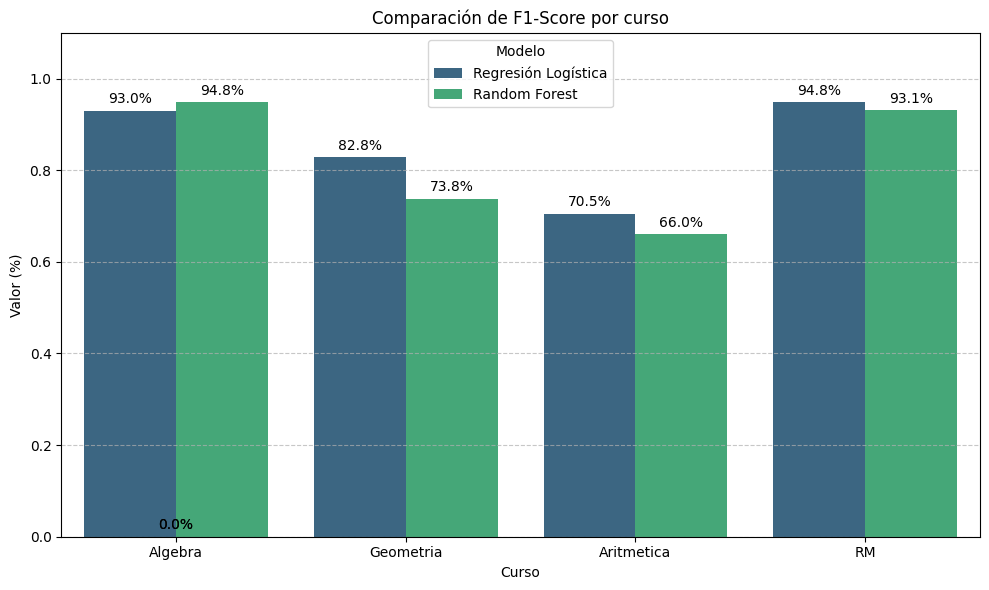

In [ ]:
comparar_metricas_modelos(
    resultados_mate_logistica,
    resultados_mate_random,
    nombre_modelo1="Regresión Logística",
    nombre_modelo2="Random Forest"
)

# POSIBLES MEJORAS PARA LA VERSIÓN FINAL

### PRUEBAS DE MULTICOLINEALIDAD

In [ ]:
def analizar_multicolinealidad(df_encoded, target_col, target_areas, titulo_area="Área"):

    # ---  Eliminar columnas objetivo del conjunto de predictores
    columnas_predictoras = [c for c in df_encoded.columns if c not in target_areas]
    X = df_encoded[columnas_predictoras].drop(columns=[target_col], errors='ignore')
    y = df_encoded[target_col]

    # ---  Matriz de correlación entre variables predictoras
    corr_matrix_vars = X.corr()

    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix_vars, cmap='coolwarm', center=0)
    plt.title(f'🔷 Matriz de correlación entre variables predictoras - {titulo_area}')
    plt.show()

    # --- Correlación entre cada variable y la variable objetivo
    corr_with_target = X.corrwith(y)
    corr_with_target_df = corr_with_target.sort_values(ascending=False).to_frame(name=f'Correlación con {target_col}')

    print(f"\n=== 🔹 Correlación entre cada variable y {target_col} ===")
    display(corr_with_target_df)

    # --- Gráfico de correlación con el objetivo
    plt.figure(figsize=(10,6))
    corr_with_target_df.plot(kind='bar', legend=False)
    plt.title(f'📊 Correlación entre cada variable y {target_col} ({titulo_area})')
    plt.ylabel('Correlación')
    plt.xlabel('Variable')
    plt.tight_layout()
    plt.show()

    return corr_matrix_vars, corr_with_target_df

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128311 (\N{LARGE BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


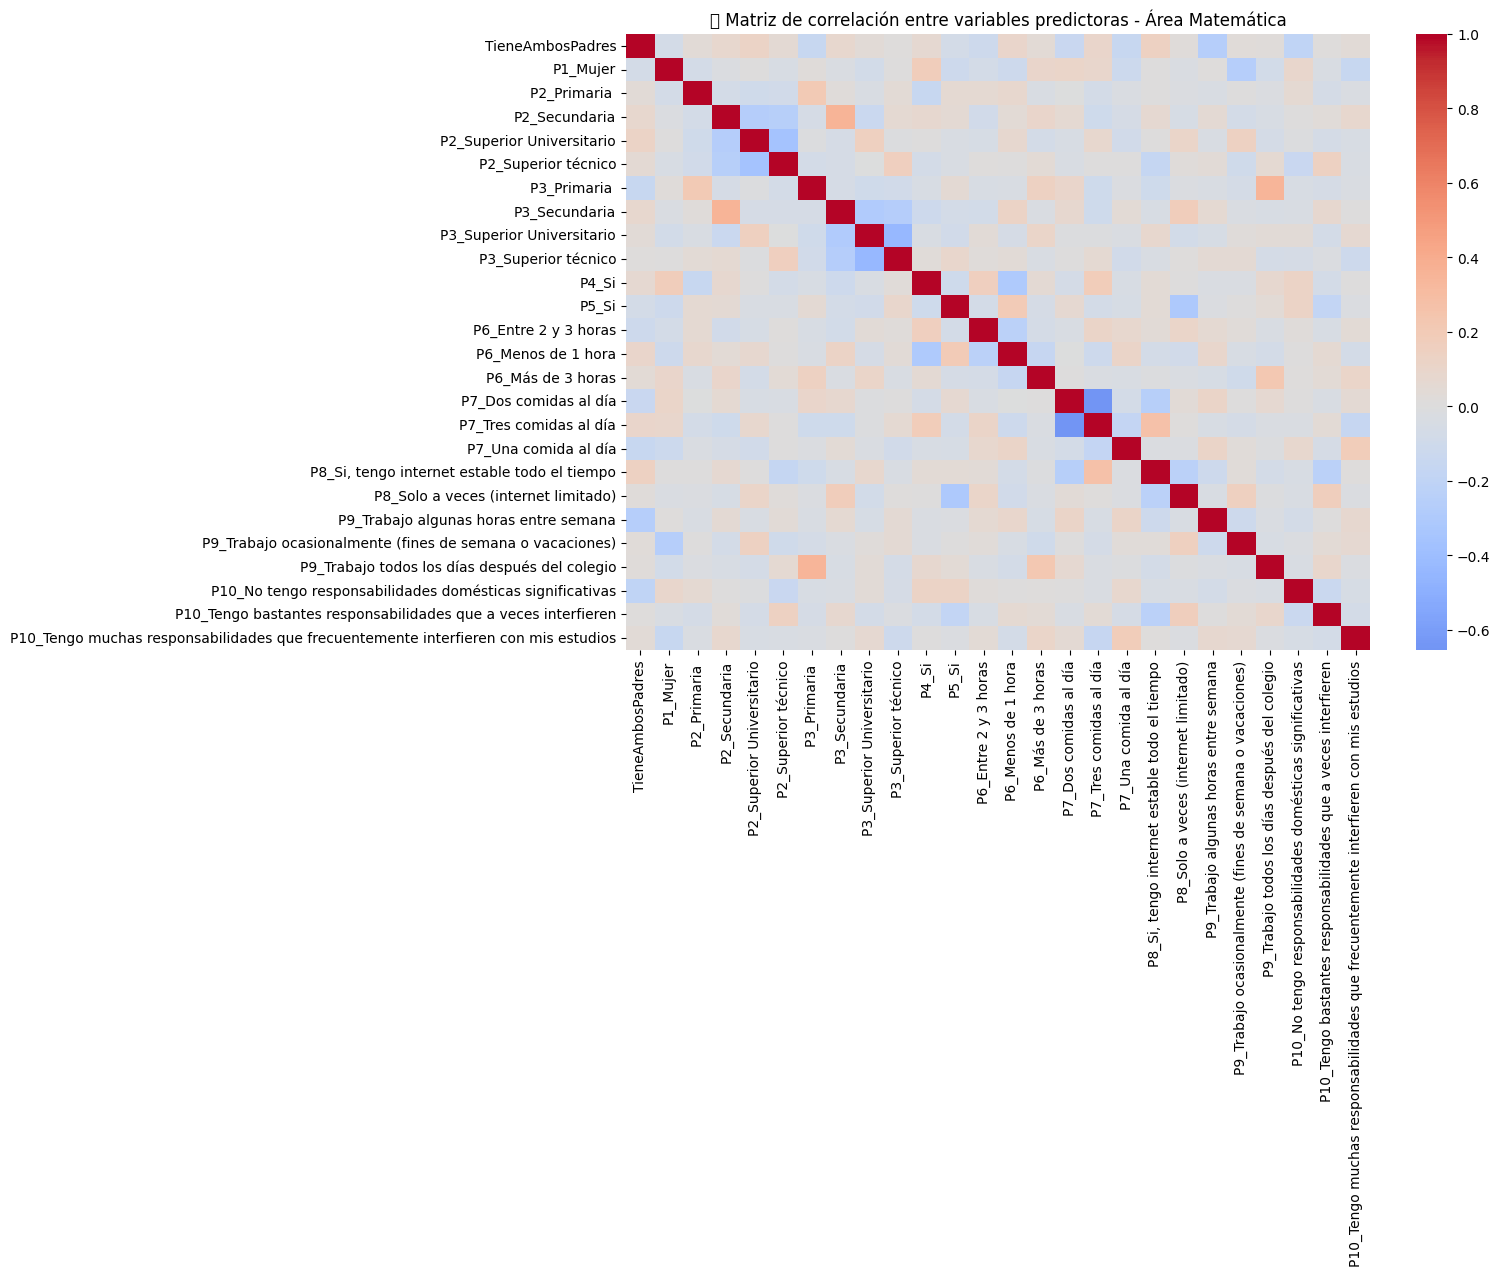


=== 🔹 Correlación entre cada variable y Matematica ===


,Correlación con Matematica
P4_Si,0.155829
P1_Mujer,0.140911
P7_Tres comidas al día,0.128733
P10_Tengo bastantes responsabilidades que a veces interfieren,0.088708
"P8_Si, tengo internet estable todo el tiempo",0.079703
P3_Superior Universitario,0.064983
P6_Entre 2 y 3 horas,0.061856
P2_Superior técnico,0.016628
TieneAmbosPadres,0.012920
P6_Más de 3 horas,0.009594


/tmp/ipython-input-1142946193.py:29: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1142946193.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


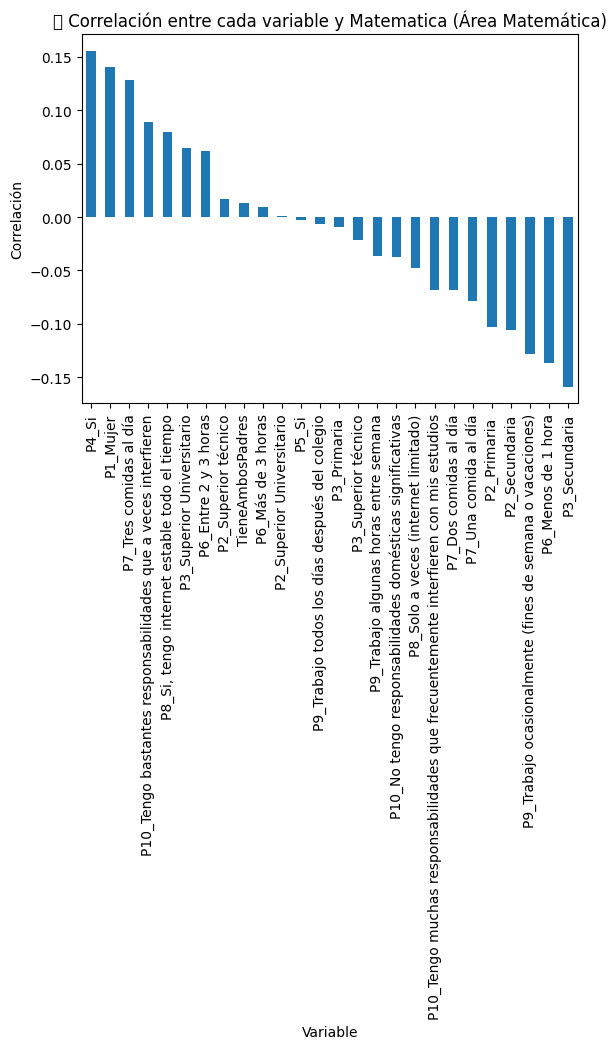

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128311 (\N{LARGE BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


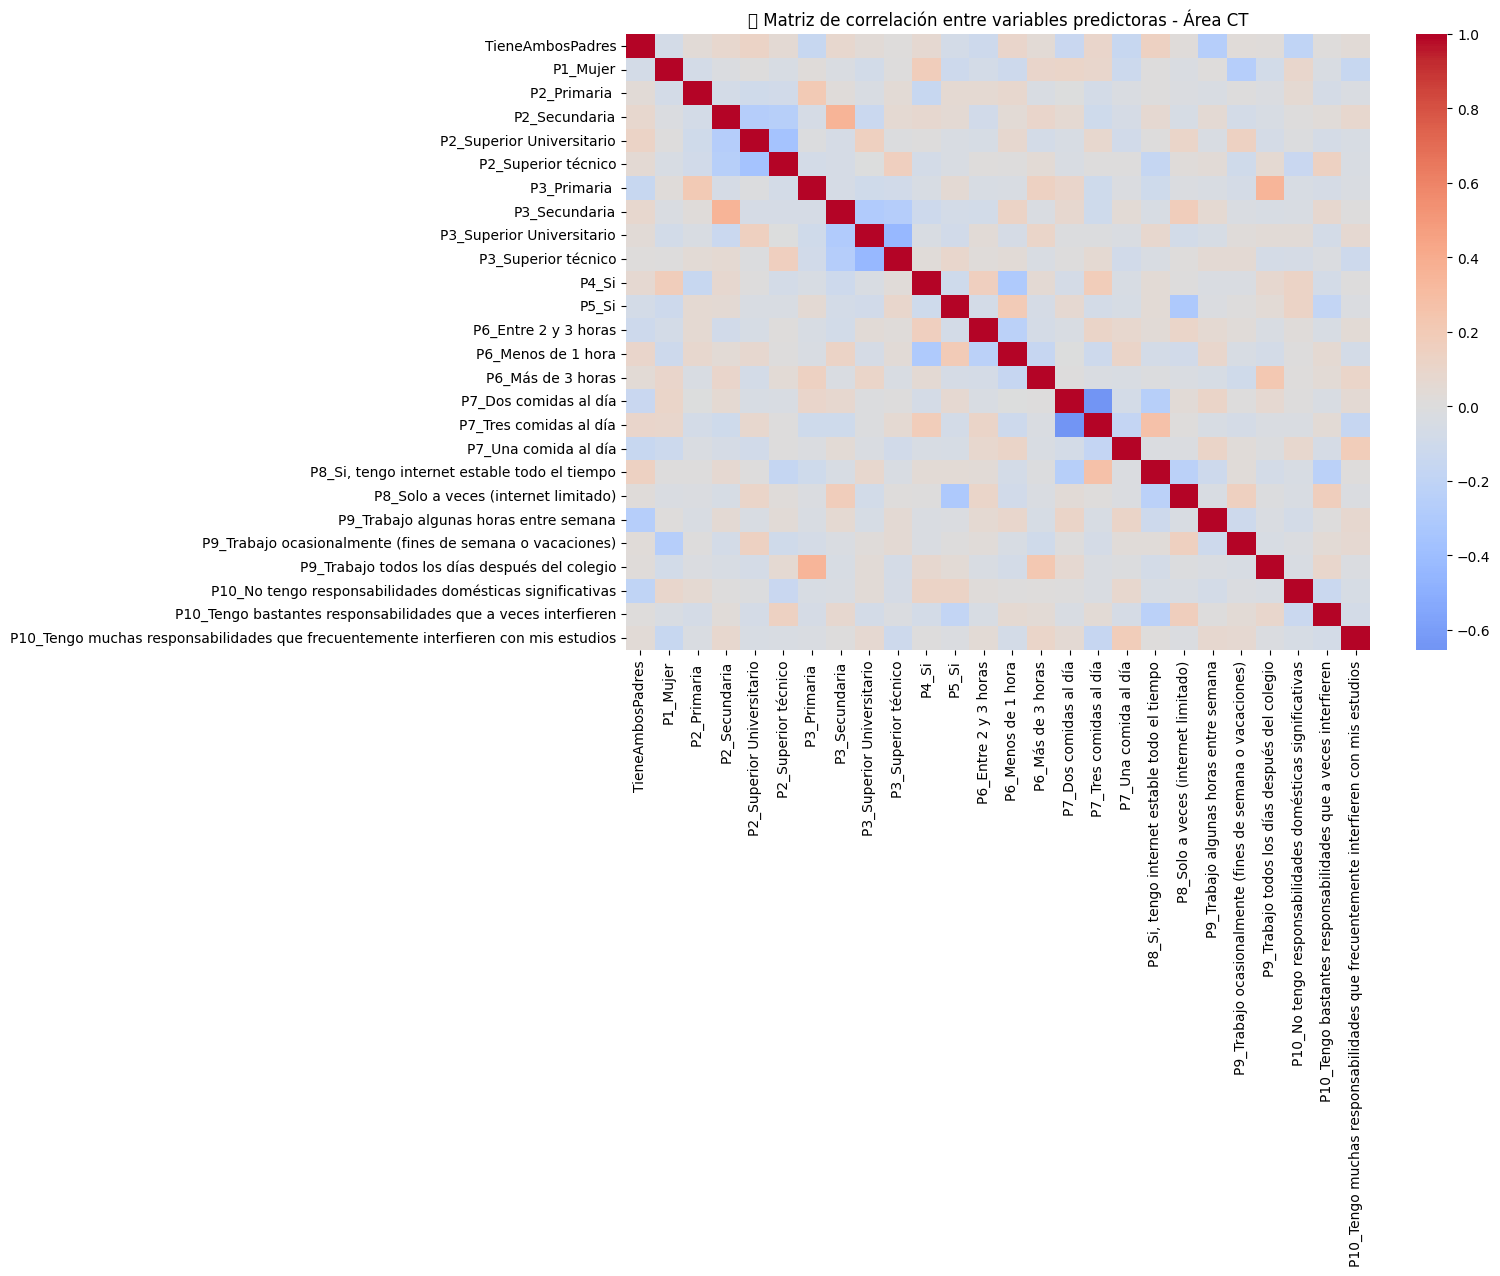


=== 🔹 Correlación entre cada variable y CT ===


,Correlación con CT
P7_Tres comidas al día,0.142081
P3_Superior Universitario,0.137010
P2_Superior Universitario,0.114195
P1_Mujer,0.095860
P6_Más de 3 horas,0.063497
P10_Tengo muchas responsabilidades que frecuentemente interfieren con mis estudios,0.051470
P2_Primaria,0.046873
P3_Primaria,0.041824
P10_Tengo bastantes responsabilidades que a veces interfieren,0.036162
P8_Solo a veces (internet limitado),0.036135


/tmp/ipython-input-1142946193.py:29: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1142946193.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


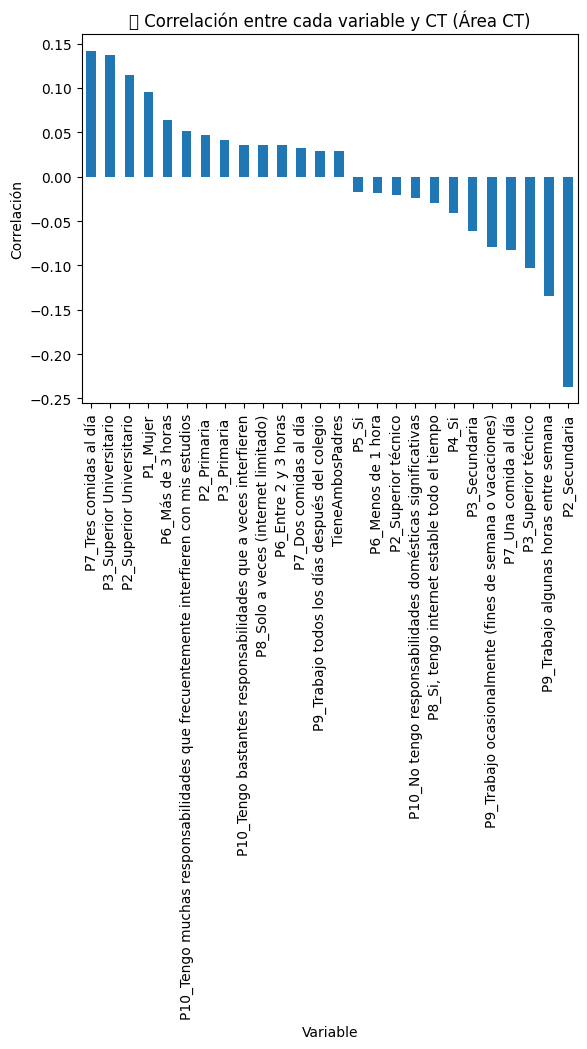

In [ ]:
# Matriz para el área de Matemática
corr_mate_vars, corr_mate_target = analizar_multicolinealidad(
    df_encoded2,
    target_col='Matematica',
    target_areas=target_areas,
    titulo_area='Área Matemática'
)

# Matriz para el área de CT
corr_ct_vars, corr_ct_target = analizar_multicolinealidad(
    df_encoded2,
    target_col='CT',
    target_areas=target_areas,
    titulo_area='Área CT'
)


# PRUEBA DE VALIDACIÓN CRUZADA

In [ ]:
def entrenar_modelos_random_forest(df, feature_cols, target_cols, n_splits=10):
    resultados = []

    for target in target_cols:
        X = df[feature_cols]
        y = df[target]

        # Configuración del modelo
        clf = RandomForestClassifier(random_state=42)

        # Validación cruzada
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        acc = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
        prec = cross_val_score(clf, X, y, cv=cv, scoring='precision_macro')
        f1 = cross_val_score(clf, X, y, cv=cv, scoring='f1_macro')

        # Entrenar modelo final y matriz de confusión
        clf.fit(X, y)
        y_pred = clf.predict(X)
        cm = confusion_matrix(y, y_pred, labels=sorted(y.unique()))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y.unique()))

        plt.figure(figsize=(5, 4))
        disp.plot(cmap='Greens', colorbar=False)
        plt.title(f"Matriz de Confusión - {target}")
        plt.show()

        resultados.append({
            'Curso': target,
            'Accuracy': round(acc.mean(), 3),
            'Precision': round(prec.mean(), 3),
            'F1-Score': round(f1.mean(), 3)
        })

    return pd.DataFrame(resultados)

In [ ]:
def entrenar_modelos_logistica(df, feature_cols, target_cols, n_splits=10):
    resultados = []

    for target in target_cols:

        X = df[feature_cols]
        y = df[target]

        # Modelo
        clf = LogisticRegression(max_iter=1000, random_state=42)

        # Validación cruzada
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        acc = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
        prec = cross_val_score(clf, X, y, cv=cv, scoring='precision_macro')
        f1 = cross_val_score(clf, X, y, cv=cv, scoring='f1_macro')

        # Entrenar modelo final y matriz de confusión
        clf.fit(X, y)
        y_pred = clf.predict(X)
        cm = confusion_matrix(y, y_pred, labels=sorted(y.unique()))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y.unique()))

        plt.figure(figsize=(5, 4))
        disp.plot(cmap='Blues', colorbar=False)
        plt.title(f"Matriz de Confusión - {target}")
        plt.show()

        resultados.append({
            'Curso': target,
            'Accuracy': round(acc.mean(), 3),
            'Precision': round(prec.mean(), 3),
            'F1-Score': round(f1.mean(), 3)
        })

    return pd.DataFrame(resultados)

<Figure size 500x400 with 0 Axes>

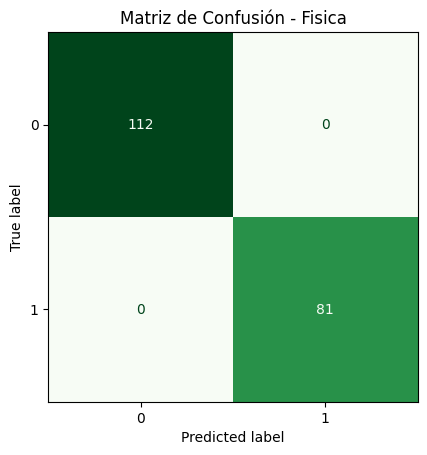

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

<Figure size 500x400 with 0 Axes>

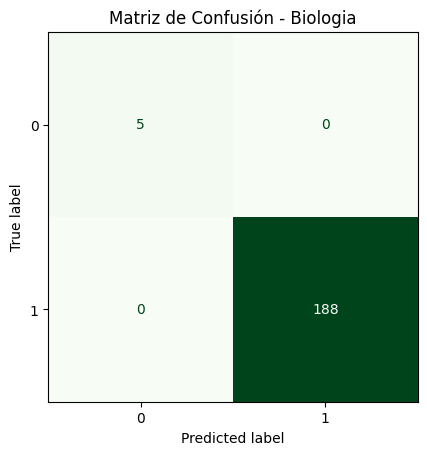

<Figure size 500x400 with 0 Axes>

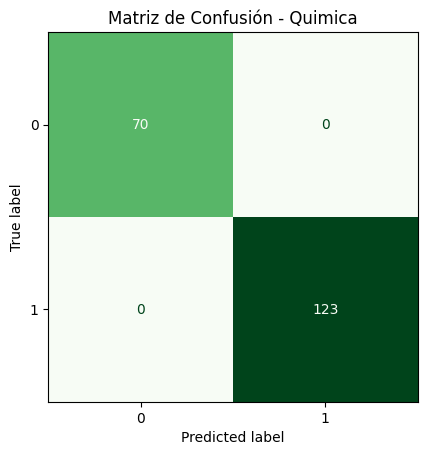

,Curso,Accuracy,Precision,F1-Score
0,Fisica,0.659,0.649,0.642
1,Biologia,0.974,0.737,0.743
2,Quimica,0.690,0.693,0.640


<Figure size 500x400 with 0 Axes>

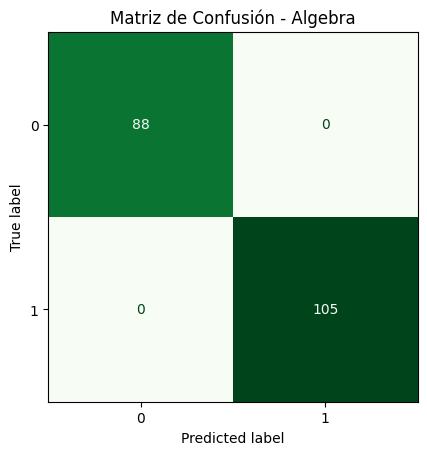

<Figure size 500x400 with 0 Axes>

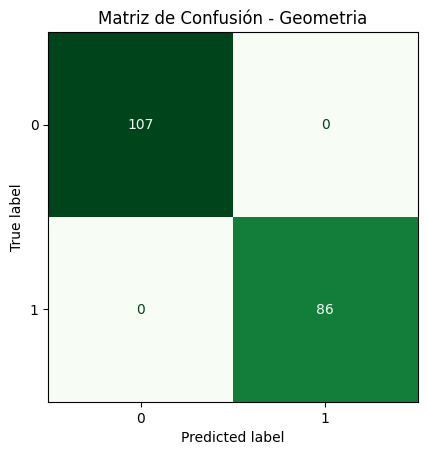

<Figure size 500x400 with 0 Axes>

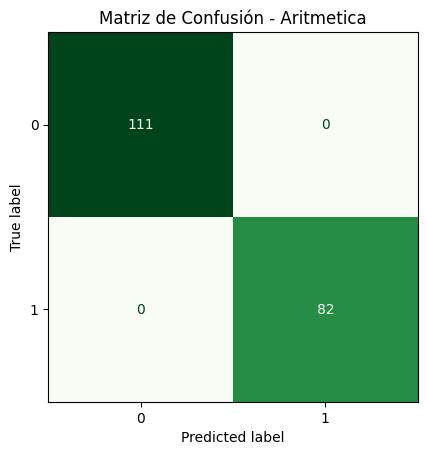

<Figure size 500x400 with 0 Axes>

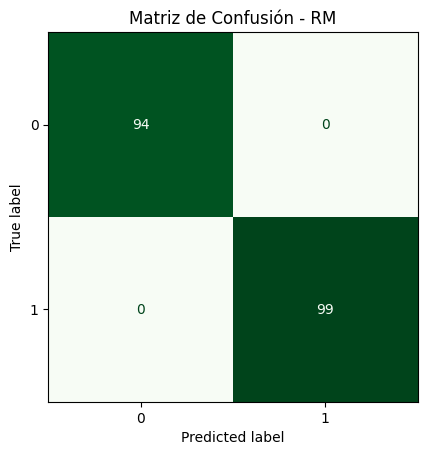

,Curso,Accuracy,Precision,F1-Score
0,Algebra,0.865,0.880,0.862
1,Geometria,0.814,0.820,0.812
2,Aritmetica,0.674,0.665,0.657
3,RM,0.907,0.911,0.906


In [ ]:
#Vemos los resultados obtenidos con cross validation con random forest
resultados_ct_cross_rf = entrenar_modelos_random_forest(df_encoded1, feature_cols, target_ct)
display(resultados_ct_cross_rf)

resultados_mate_cross_rf= entrenar_modelos_random_forest(df_encoded1, feature_cols, target_mate)
display(resultados_mate_cross_rf)

<Figure size 500x400 with 0 Axes>

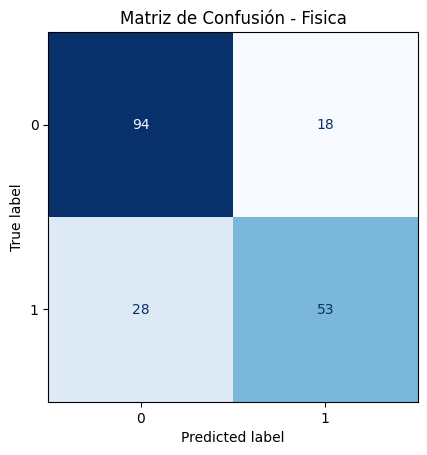

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

<Figure size 500x400 with 0 Axes>

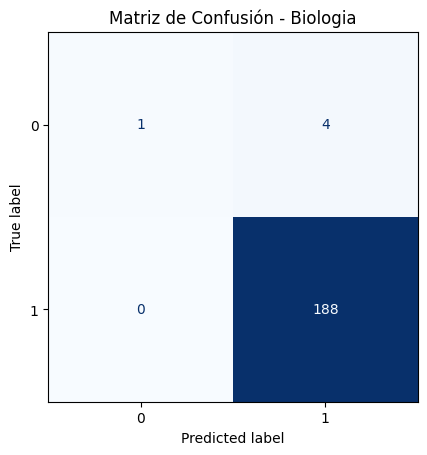

<Figure size 500x400 with 0 Axes>

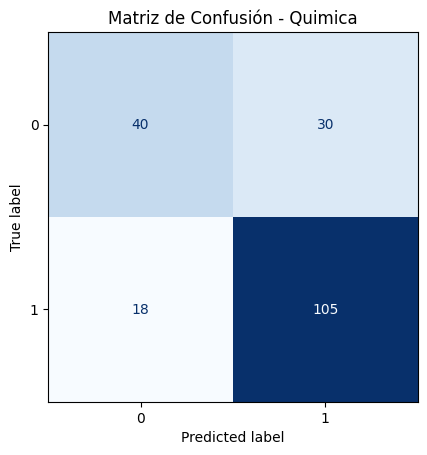

,Curso,Accuracy,Precision,F1-Score
0,Fisica,0.686,0.679,0.672
1,Biologia,0.974,0.737,0.743
2,Quimica,0.685,0.664,0.641


<Figure size 500x400 with 0 Axes>

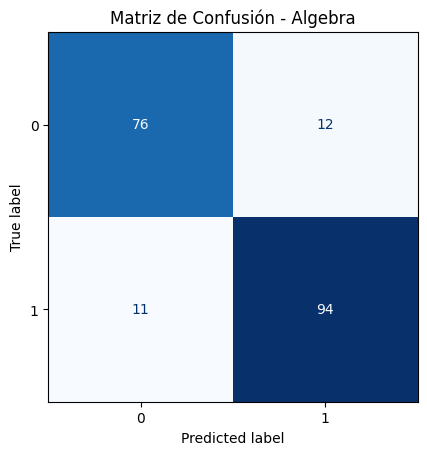

<Figure size 500x400 with 0 Axes>

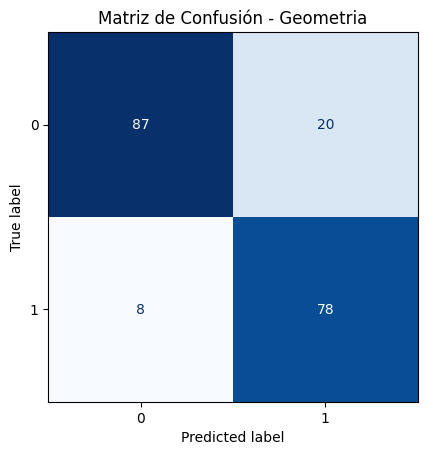

<Figure size 500x400 with 0 Axes>

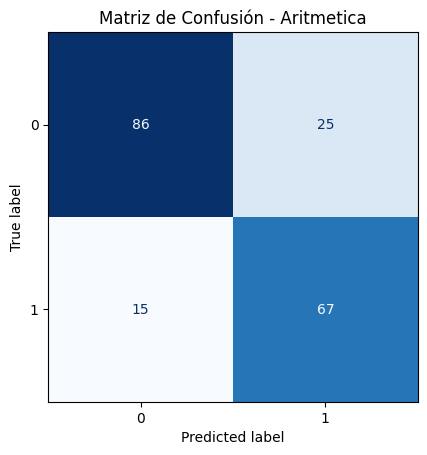

<Figure size 500x400 with 0 Axes>

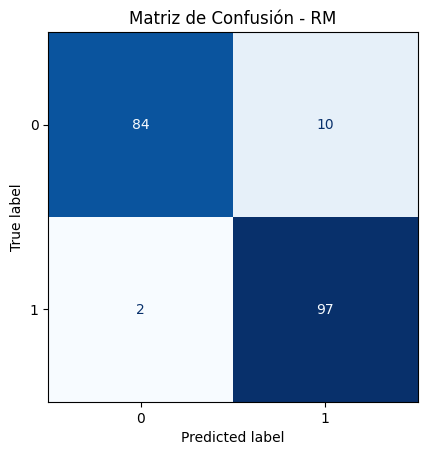

,Curso,Accuracy,Precision,F1-Score
0,Algebra,0.876,0.888,0.873
1,Geometria,0.835,0.849,0.832
2,Aritmetica,0.715,0.714,0.711
3,RM,0.938,0.946,0.937


In [ ]:
#Ahora probamos validacion cruzada con Regresión Logistica
resultados_ct_cross_rl = entrenar_modelos_logistica(df_encoded1, feature_cols, target_ct)
display(resultados_ct_cross_rl)

resultados_mate_cross_rl= entrenar_modelos_logistica(df_encoded1, feature_cols, target_mate)
display(resultados_mate_cross_rl)